# Single qubit gates
## First, isolated qubit

In [148]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
#here, configure the path to the directory for pre-defined functions.
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_evolgates_double as gates_double
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [121]:
savefig = False
from matplotlib import rcParams
if savefig == True:
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
else:
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.serif'] = ['Arial']
    
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/'

In [72]:
#Device parameters
nlev_lc = 20
nlev_single = 5  # The number of single-qubit levels to show.
take_data_from_input_file = False

if not take_data_from_input_file:
    # Parameters of the first fluxonium.
    E_L = 1  # inductive energy
    E_C = 1.0  # charging energy
    E_J = 7  # Josephson energy
    phi_ext = 0.96*np.pi  # external phase shift

qubit = fluxonium.Fluxonium(E_J = E_J, E_C=E_C, E_L=E_L, phi_ext=phi_ext, nlev = nlev_single, nlev_lc = nlev_lc)
H_nodrive = qubit.H()

psi0 = basis(nlev_single, 0)
psi1 = basis(nlev_single, 1)
psi2 = basis(nlev_single, 2)
psi3 = basis(nlev_single, 3)
psi4 = basis(nlev_single, 4)

P0 = psi0 * psi0.dag()
P1 = psi1 * psi1.dag()
P2 = psi2 * psi2.dag()
P3 = psi3 * psi3.dag()
P4 = psi4 * psi4.dag()

## Using propagator to minimize leakage

In [108]:
#Gate parameter
T_gate = 8 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 1
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.0

ini_state = 0
fin_state = 2
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

7.978718853385303e-06


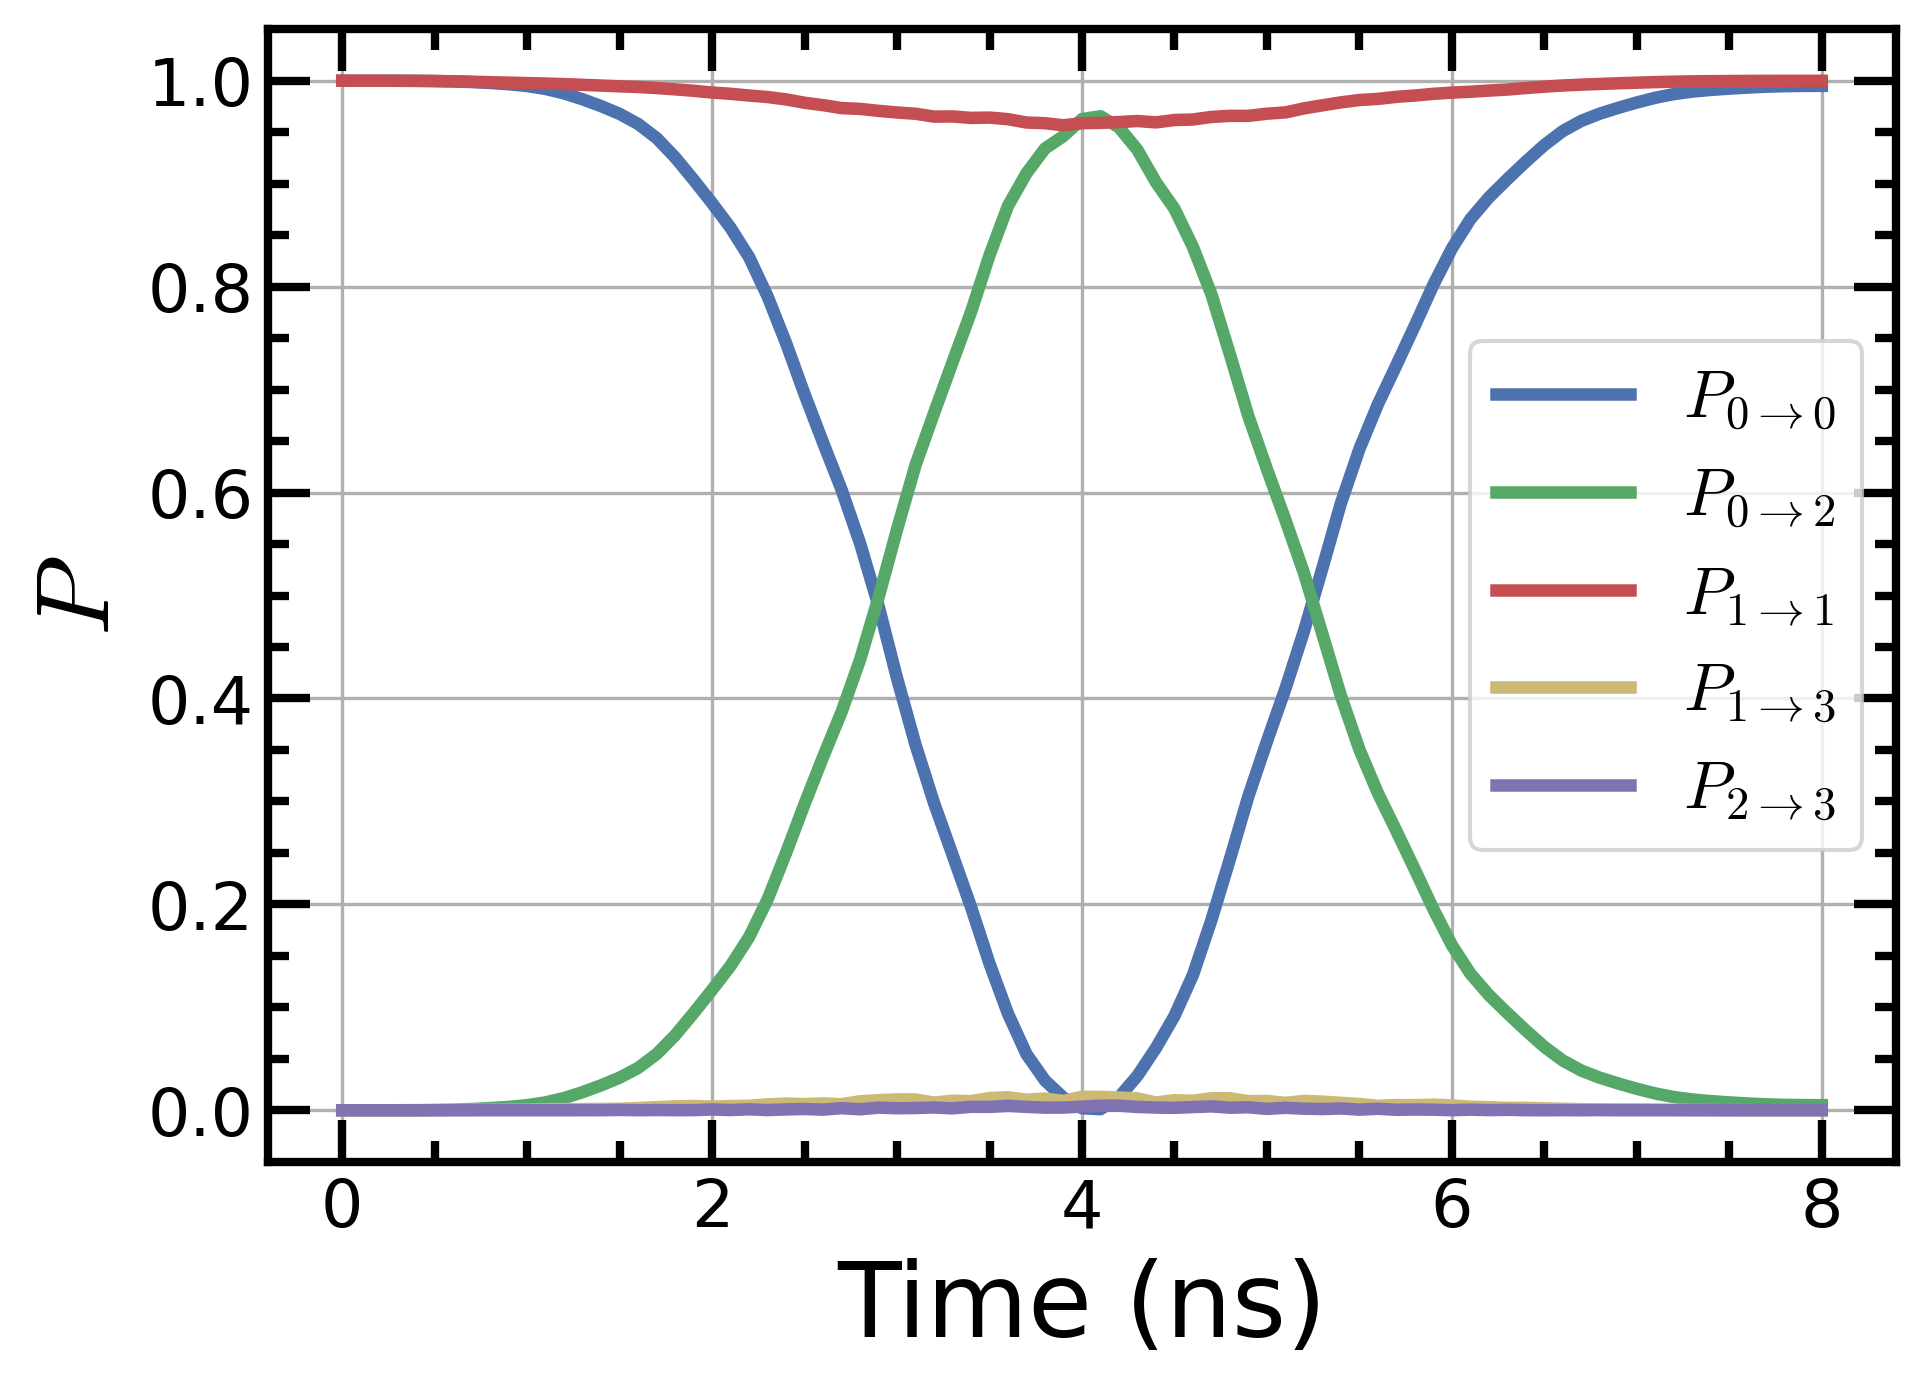

In [109]:
trans_prob_00 = gates.prob_transition(U_t, psi0, psi0)
trans_prob_02 = gates.prob_transition(U_t, psi0, psi2)
trans_prob_11 = gates.prob_transition(U_t, psi1, psi1)
trans_prob_13 = gates.prob_transition(U_t, psi1, psi3)
trans_prob_23 = gates.prob_transition(U_t, psi2, psi3)

plt.figure(figsize = [7,5])
plt.plot(t_points, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
# plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

print (1-trans_prob_02[-1]-trans_prob_00[-1])

In [110]:
def leakage_02(drag_coeff):
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    trans_prob_00 = gates.prob_transition(U_t, psi0, psi0)
    trans_prob_02 = gates.prob_transition(U_t, psi0, psi2)
    return 1 - trans_prob_00[-1]-trans_prob_02[-1]

opt = minimize(leakage_02, x0 = [0.0])
print (opt.fun)
print (opt.x[0])

4.072739770037475e-06
0.2732870841184422


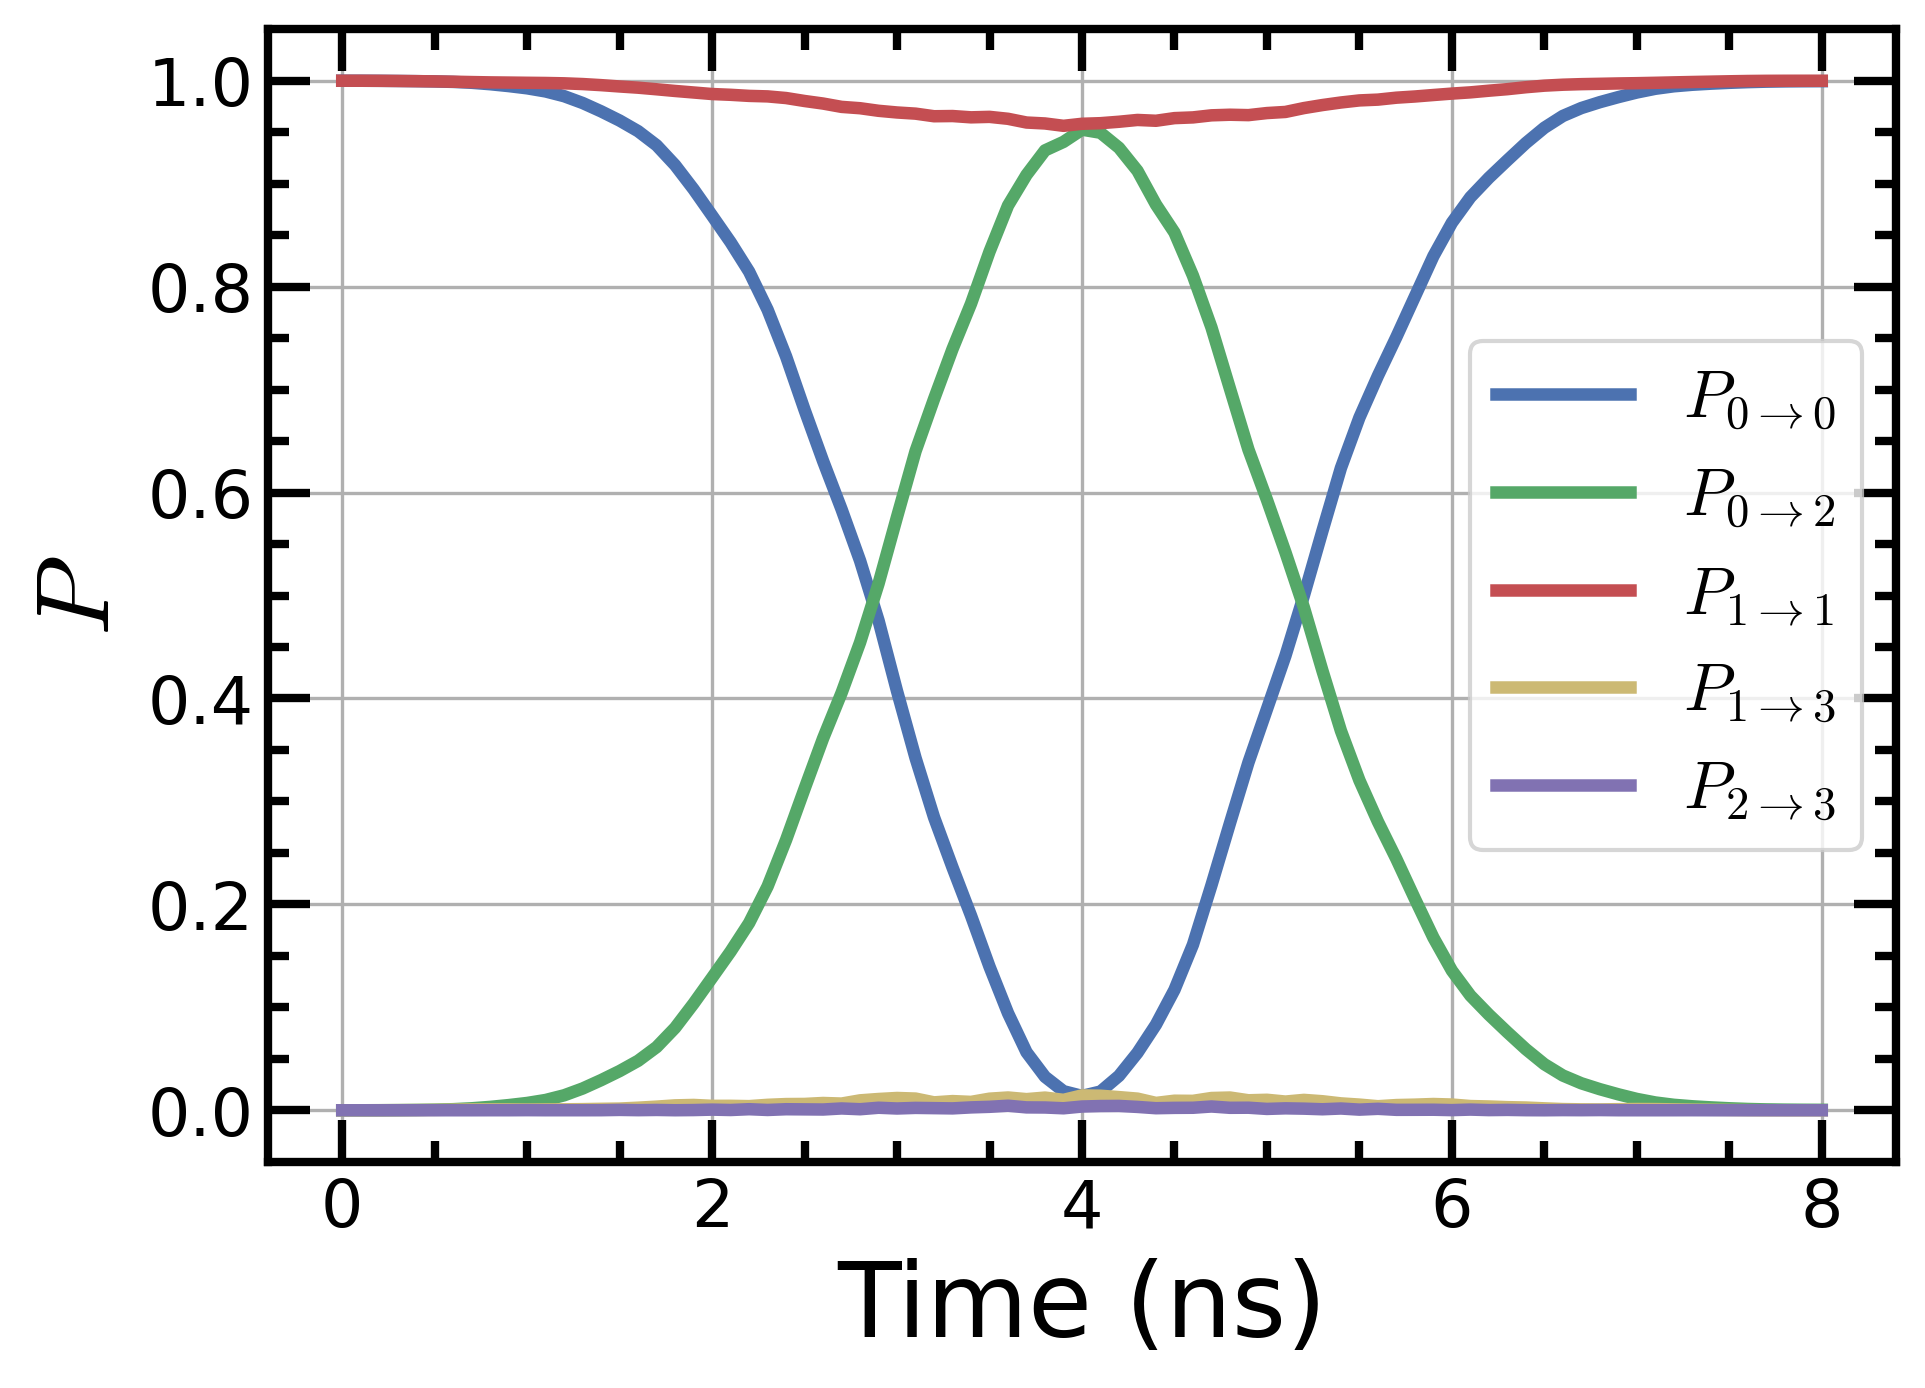

In [111]:
drag_coeff = opt.x[0]

ini_state = 0
fin_state = 2
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

trans_prob_00 = gates.prob_transition(U_t, psi0, psi0)
trans_prob_02 = gates.prob_transition(U_t, psi0, psi2)
trans_prob_11 = gates.prob_transition(U_t, psi1, psi1)
trans_prob_13 = gates.prob_transition(U_t, psi1, psi3)
trans_prob_23 = gates.prob_transition(U_t, psi2, psi3)

plt.figure(figsize = [7,5])
plt.plot(t_points, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()

### 2-3 transition

In [116]:
#Gate parameter
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 1
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = False
drag_coeff = 0.5

ini_state = 2
fin_state = 3
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

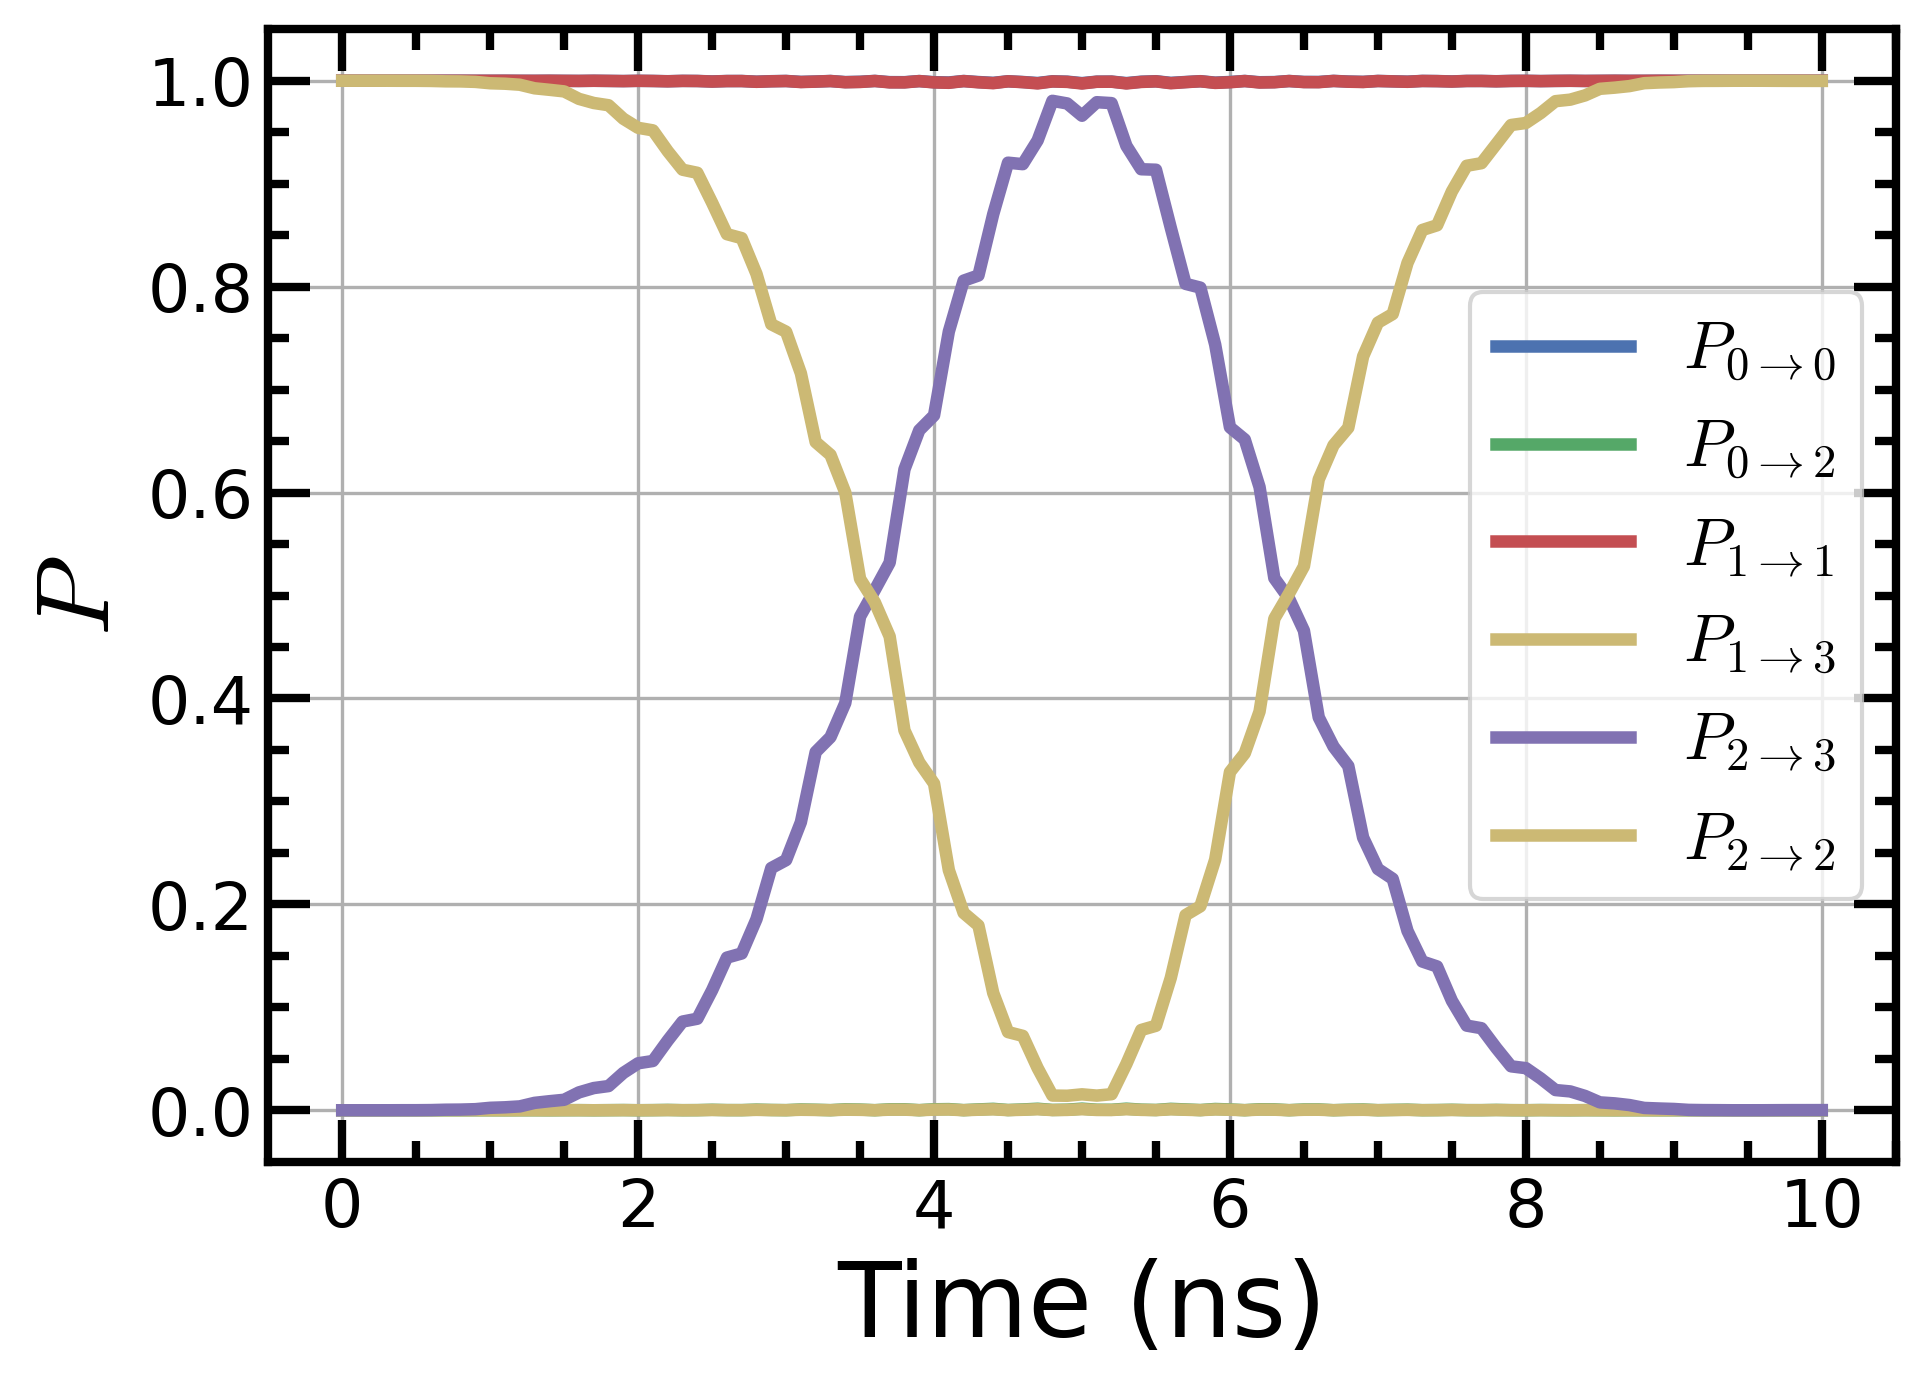

In [118]:
trans_prob_00 = gates.prob_transition(U_t, psi0, psi0)
trans_prob_02 = gates.prob_transition(U_t, psi0, psi2)
trans_prob_11 = gates.prob_transition(U_t, psi1, psi1)
trans_prob_13 = gates.prob_transition(U_t, psi1, psi3)
trans_prob_23 = gates.prob_transition(U_t, psi2, psi3)
trans_prob_22 = gates.prob_transition(U_t, psi2, psi2)

plt.figure(figsize = [7,5])
plt.plot(t_points, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.plot(t_points, trans_prob_22, label=r'$P_{2\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()

## Applying two drives at the same time

In [152]:
#Gate parameter
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 0.5
delta_omega_d1 = 0
delta_omega_d2 = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.0

ini_state1 = 0
fin_state1 = 2
omega_d_1 = qubit.freq(ini_state1,fin_state1) + delta_omega_d1
matr_el_1 = np.abs(qubit.n_ij(ini_state1,fin_state1))

ini_state2 = 1
fin_state2 = 3
omega_d_2 = qubit.freq(ini_state2,fin_state2) + delta_omega_d2
matr_el_2 = np.abs(qubit.n_ij(ini_state2,fin_state2))

epsilon = drive_amplitude_factor/(matr_el_1+matr_el_2)

H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates_double.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient_1 = drag_coeff, DRAG_coefficient_2 = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d_1=omega_d_2,omega_d_2=omega_d_2)
# U_nothing = gates.evolution_operator_microwave(
#                 -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
#                 T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

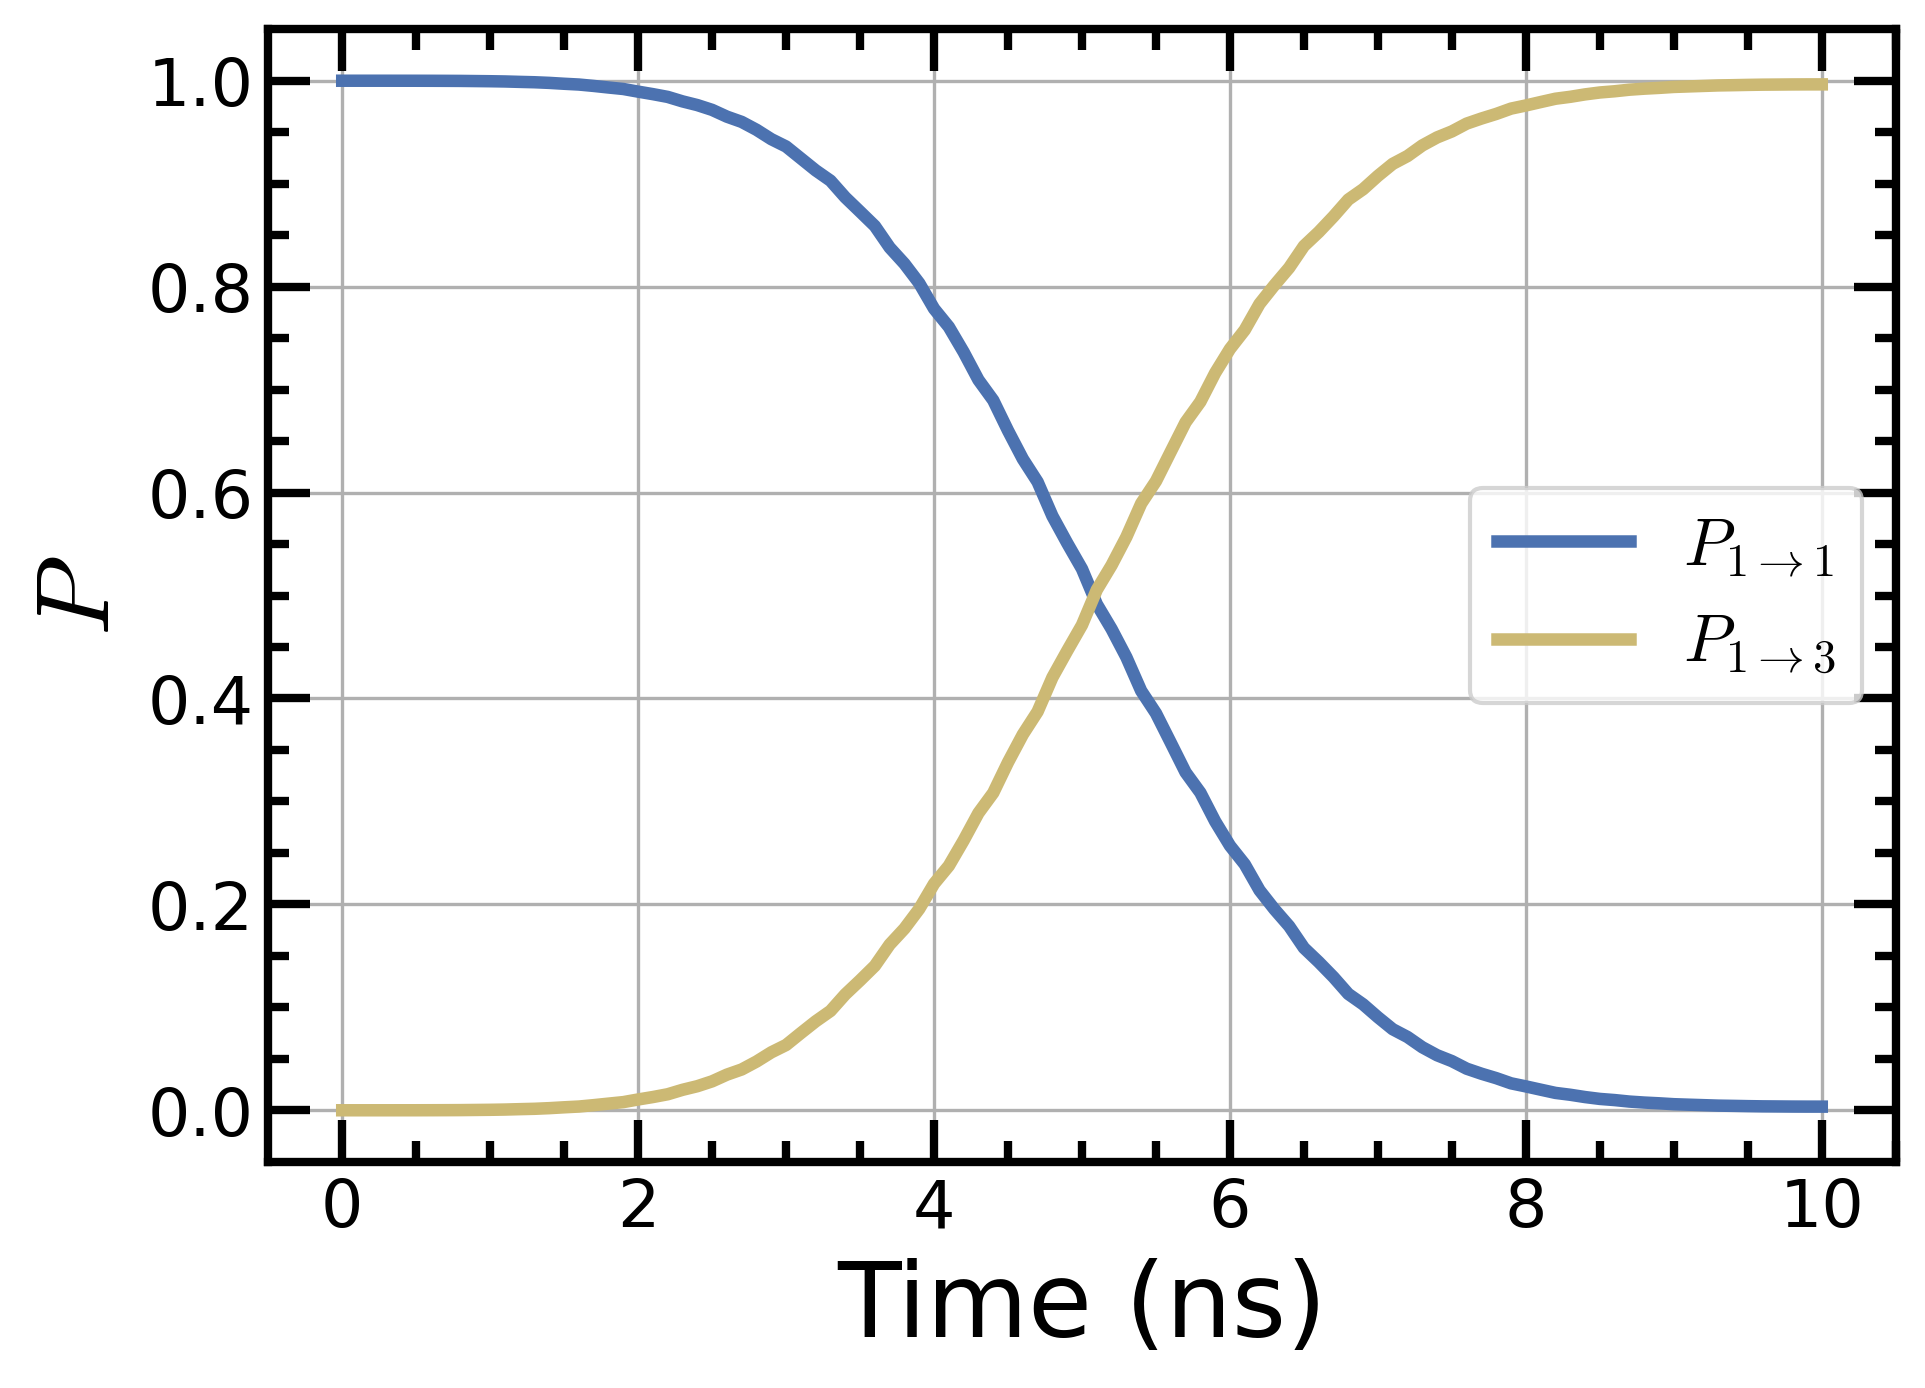

In [153]:
trans_prob_00 = gates.prob_transition(U_t, psi0, psi0)
trans_prob_02 = gates.prob_transition(U_t, psi0, psi2)
trans_prob_11 = gates.prob_transition(U_t, psi1, psi1)
trans_prob_13 = gates.prob_transition(U_t, psi1, psi3)
trans_prob_23 = gates.prob_transition(U_t, psi2, psi3)
trans_prob_22 = gates.prob_transition(U_t, psi2, psi2)

plt.figure(figsize = [7,5])
# plt.plot(t_points, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
# plt.plot(t_points, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
# plt.plot(t_points, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
# plt.plot(t_points, trans_prob_22, label=r'$P_{2\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()

In [139]:
psi_ini = psi0
evol_states_1 = gates_double.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d_1=omega_d_1, omega_d_2=omega_d_2, DRAG_coefficient_1= drag_coeff,DRAG_coefficient_2= drag_coeff)

In [ ]:
#Gate parameter
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 0.25
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = False
drag_coeff = 0.5

ini_state = 2
fin_state = 3

comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

psi_ini = evol_states_1[-1]
evol_states_2 = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient= drag_coeff)

## Solving state vectors 

## $\pi$- pulses 0-2 and 1-3

In [79]:
#Gate parameter
T_gate = 5 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 0.5
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = False
drag_coeff = 0.5

ini_state = 0
fin_state = 2
psi_ini = psi1
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient= drag_coeff)

Leakage error = 0.9998236783858481


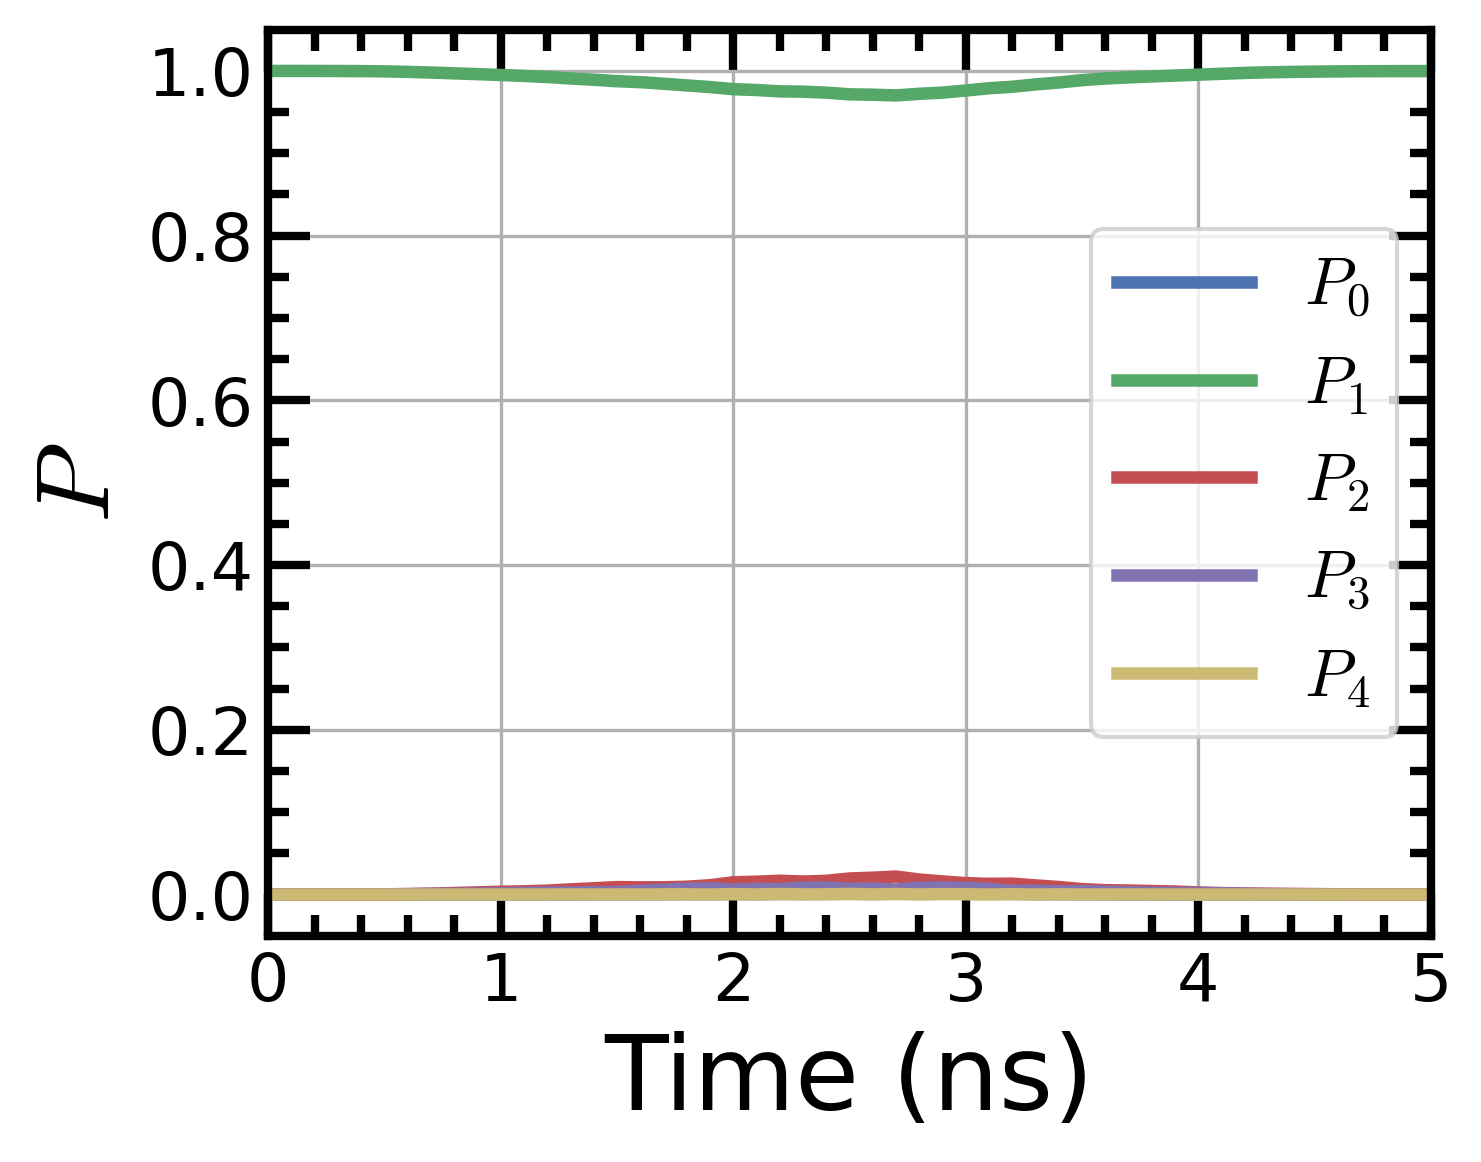

In [80]:
plt.figure(figsize = [5,4])
plt.plot(t_points, expect(P0,evol_states_ideal), label = r'$P_0$')
plt.plot(t_points, expect(P1,evol_states_ideal), label = r'$P_1$')
plt.plot(t_points, expect(P2,evol_states_ideal), label = r'$P_2$')
plt.plot(t_points, expect(P3,evol_states_ideal), label = r'$P_3$')
plt.plot(t_points, expect(P4,evol_states_ideal), label = r'$P_4$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.xlim([t_points[0],t_points[-1]])
plt.legend()
plt.grid()
# plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))
print ('Leakage error =', str(1-expect(P2,evol_states_ideal)[-1] - expect(P0,evol_states_ideal)[-1]))

In [54]:
from scipy.optimize import minimize
def leakage_func(drag_coeff):
    evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient= drag_coeff)
    return (1-expect(P0,evol_states_ideal)[-1] - expect(P2,evol_states_ideal)[-1])
opt = minimize(leakage_func, x0 = [0.5])
print (opt.fun)

0.9998236783858494


## Sweep gate time, optimize parameters, plot leakage

In [55]:
gate_time = np.linspace(1,20,21)
leakage02 = np.zeros_like(gate_time)
drag = True
delta_omega_d_opt02 = np.zeros_like(gate_time)
drag_coeff_opt02 = np.zeros_like(gate_time)
for idx,T_gate in enumerate(gate_time):
    t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
    def leakage_func(x):
        delta_omega_d = x[0]
#         drag_coeff = x[1]
#         omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
        evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 = psi_ini, t_points = t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient = drag_coeff)
        return (1-expect(P2,evol_states_ideal)[-1] - expect(P0,evol_states_ideal)[-1])
    opt = minimize(leakage_func, x0 = [0,0])
    leakage02[idx] = opt.fun
    delta_omega_d_opt02[idx] = opt.x[0]
#     drag_coeff_opt02 [idx] = opt.x[1]

(1.0, 20.0)

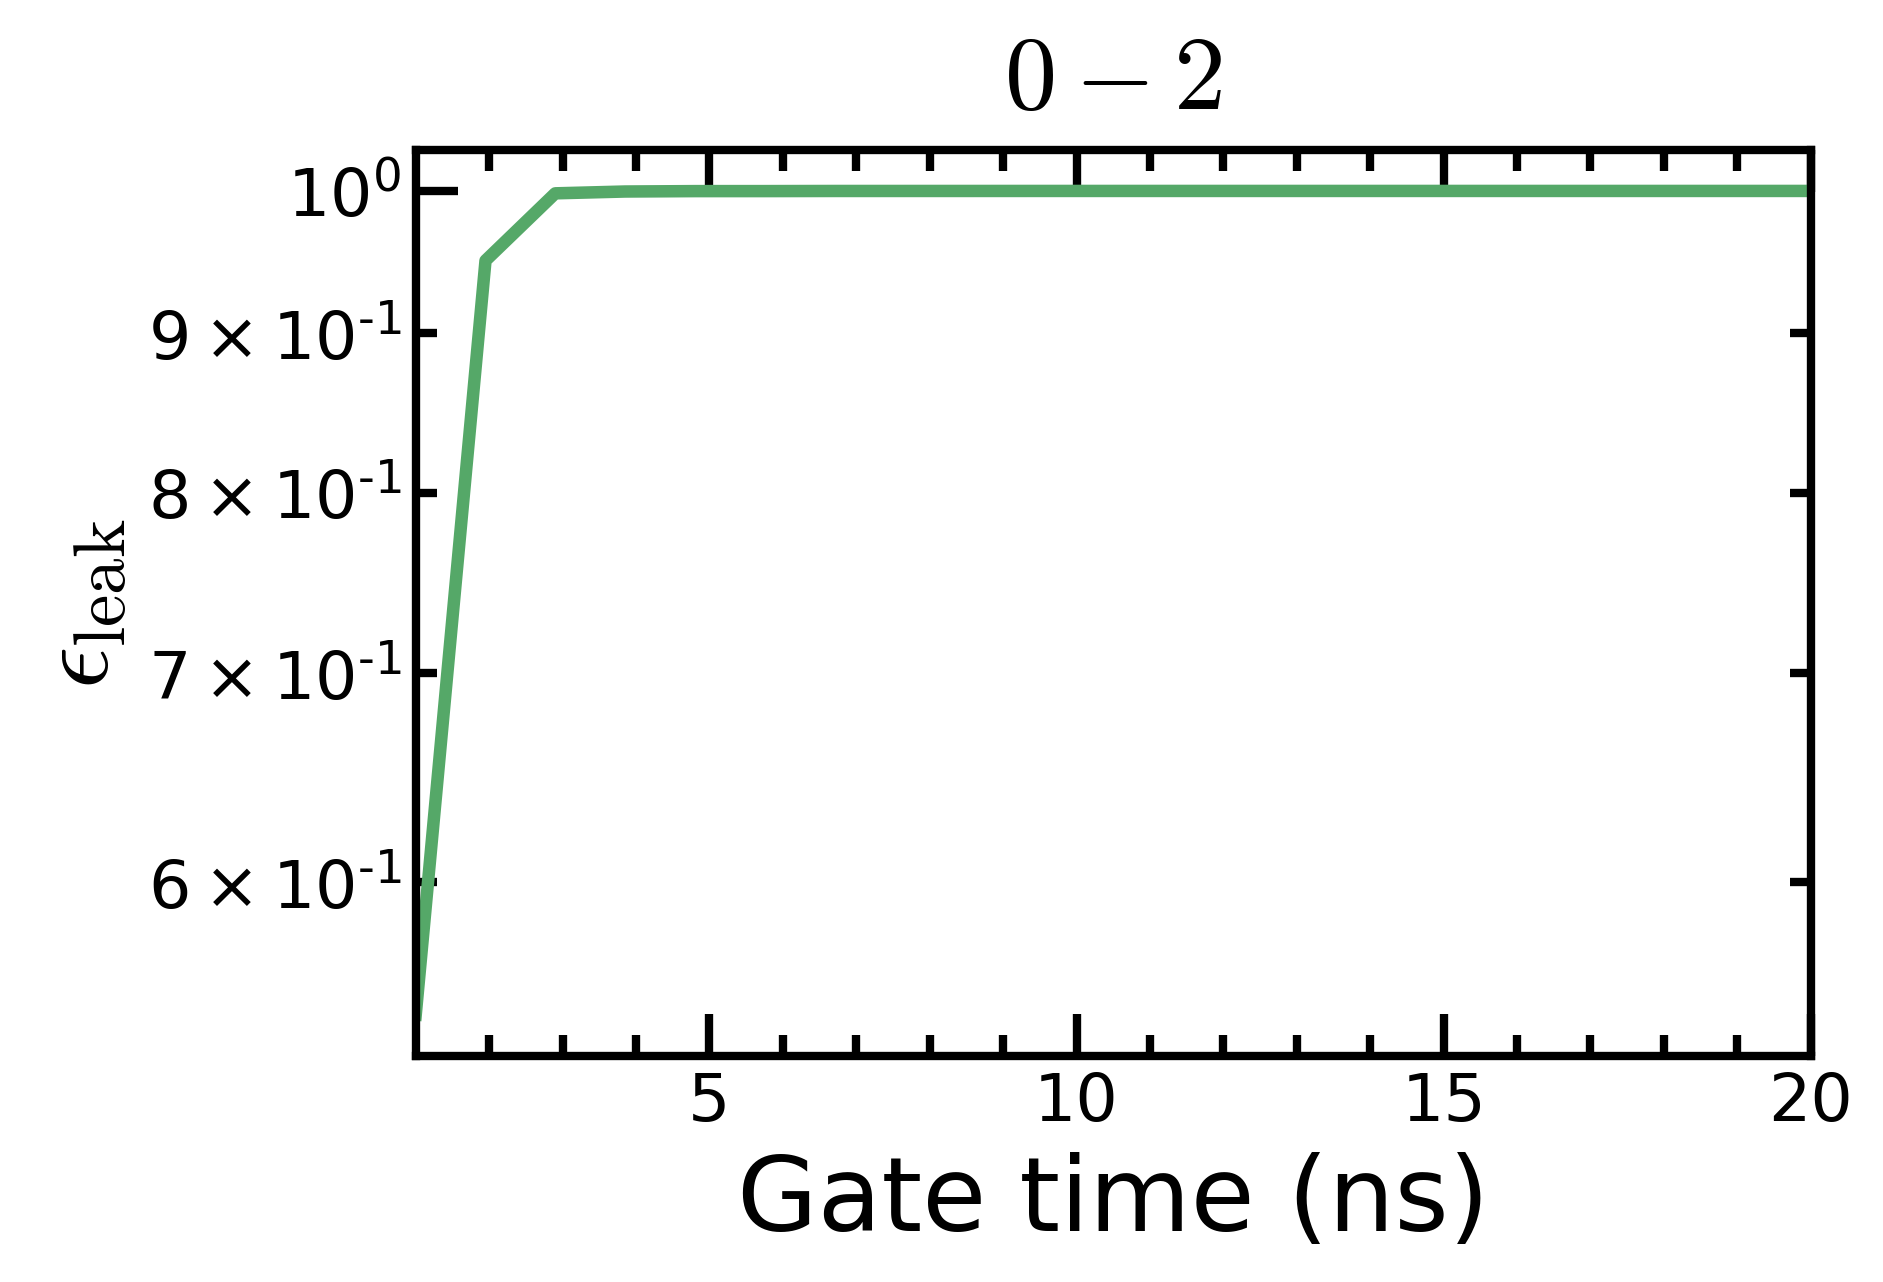

In [56]:
plt.semilogy(gate_time, leakage02, color = 'C1')
plt.xlabel('Gate time (ns)')
plt.ylabel(r'$\epsilon_\mathrm{leak}$')
plt.title(r'$0-2$')
plt.xlim([gate_time[0], gate_time[-1]])

(1.0, 20.0)

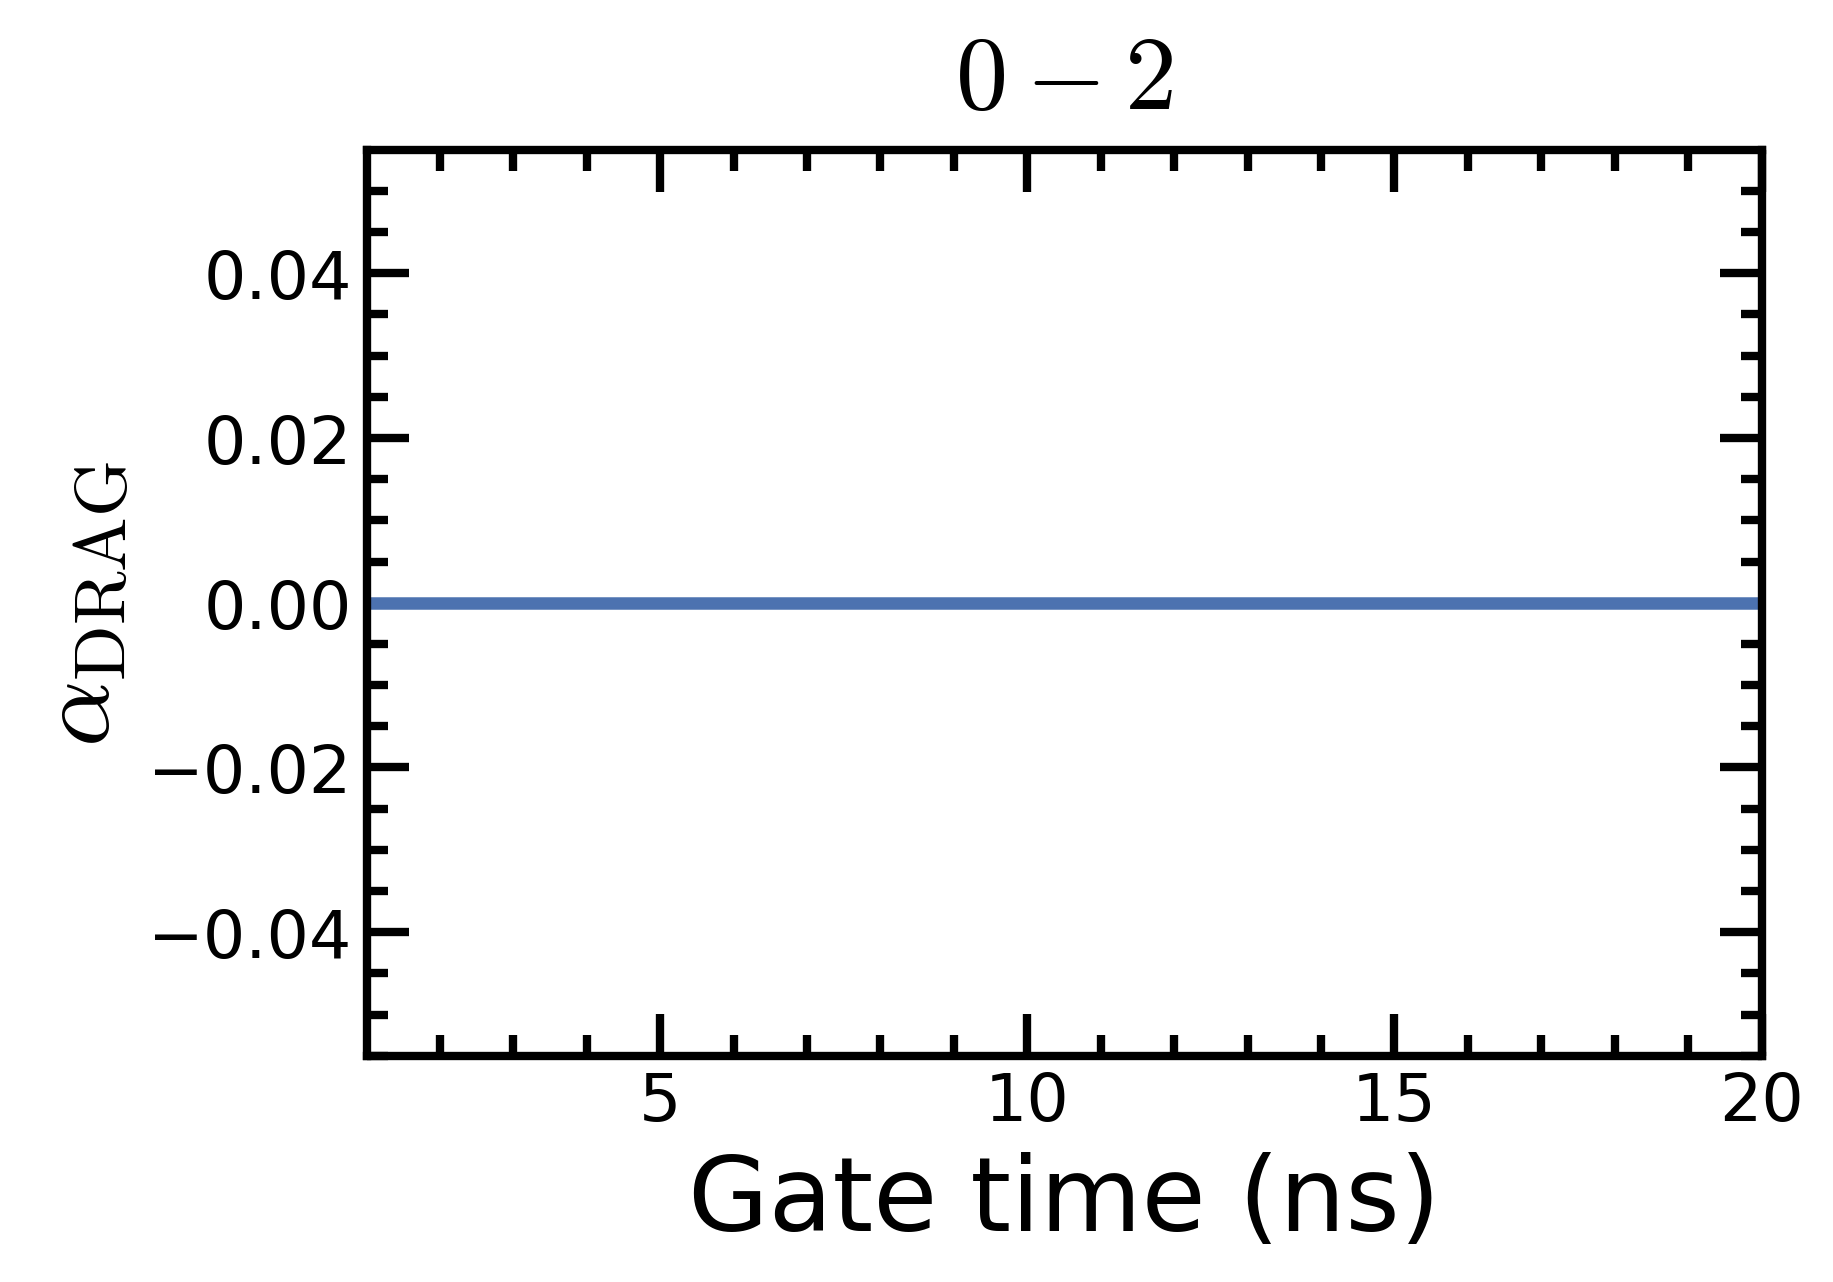

In [57]:
plt.plot(gate_time, drag_coeff_opt02)
plt.xlabel('Gate time (ns)')
plt.ylabel(r'$\alpha_\mathrm{DRAG}$')
plt.title(r'$0-2$')
plt.xlim([gate_time[0], gate_time[-1]])

## 1-3

In [58]:
#Gate parameter
T_gate = 5 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 0.5
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = False
drag_coeff = 0.5

ini_state = 1
fin_state = 3
psi_ini = psi1
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient= drag_coeff)

Leakage error = 8.415137902906267e-05


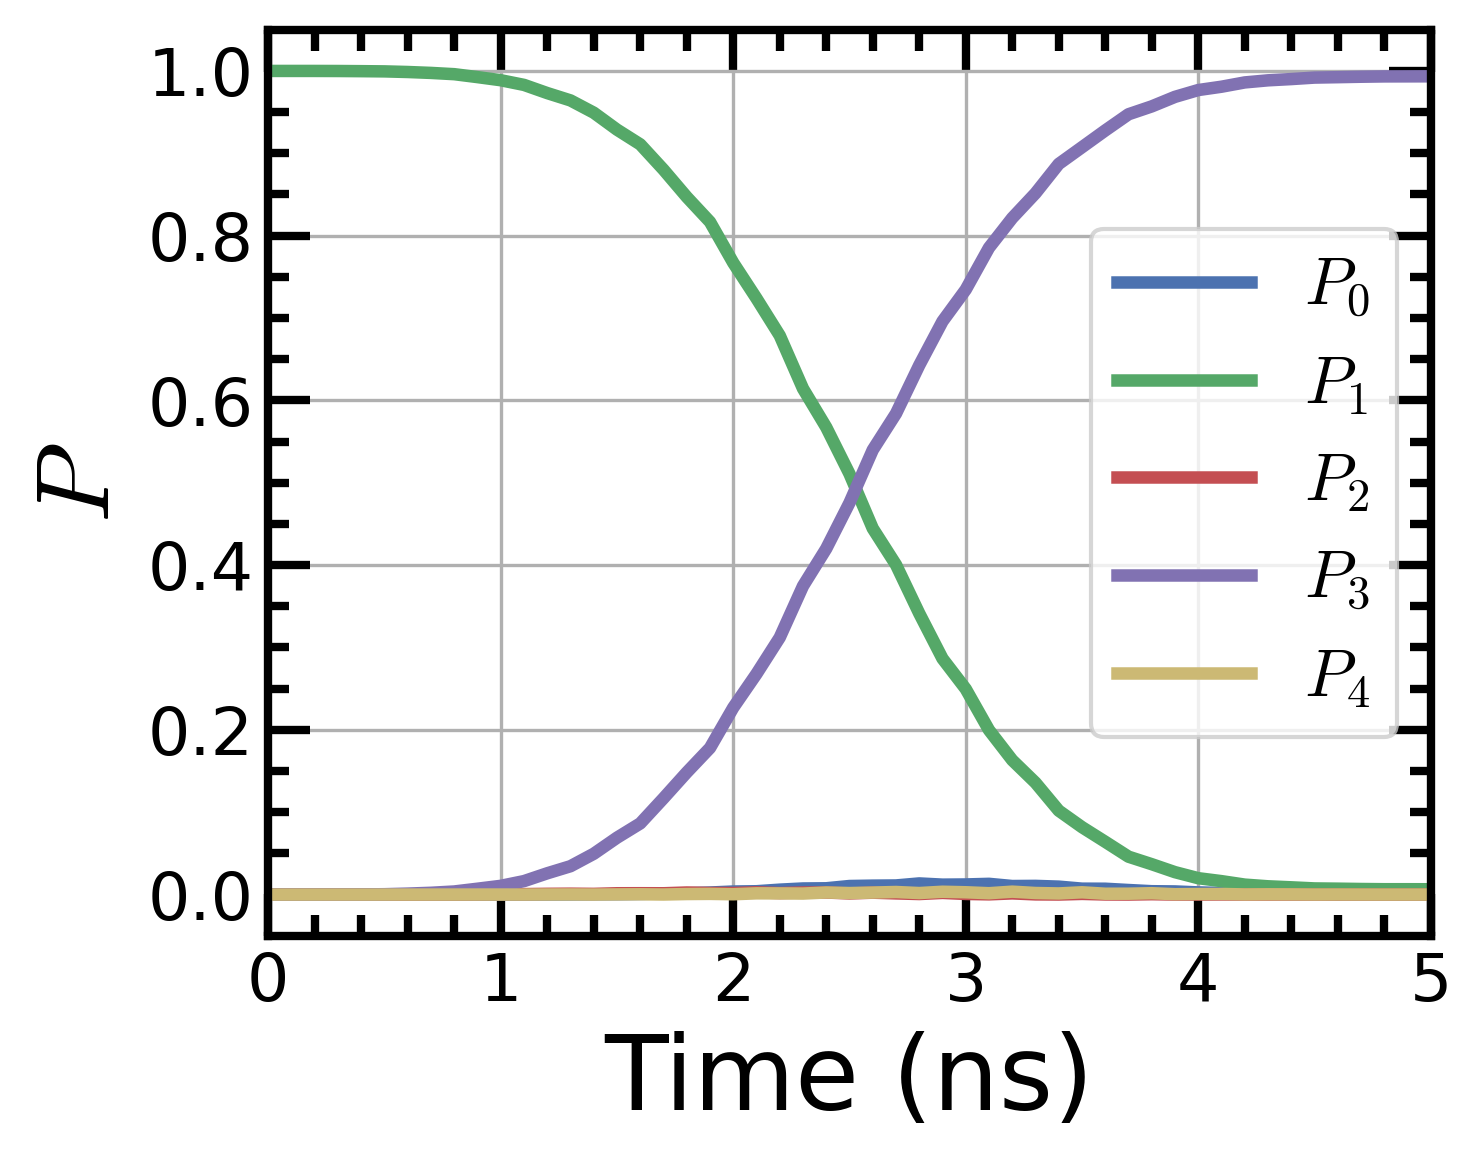

In [59]:
plt.figure(figsize = [5,4])
plt.plot(t_points, expect(P0,evol_states_ideal), label = r'$P_0$')
plt.plot(t_points, expect(P1,evol_states_ideal), label = r'$P_1$')
plt.plot(t_points, expect(P2,evol_states_ideal), label = r'$P_2$')
plt.plot(t_points, expect(P3,evol_states_ideal), label = r'$P_3$')
plt.plot(t_points, expect(P4,evol_states_ideal), label = r'$P_4$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.xlim([t_points[0],t_points[-1]])
plt.legend()
plt.grid()
# plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))
print ('Leakage error =', str(1-expect(P1,evol_states_ideal)[-1] - expect(P3,evol_states_ideal)[-1]))

In [60]:
gate_time = np.linspace(1,20,21)
leakage13 = np.zeros_like(gate_time)
drag = True
drag_coeff_opt13 = np.zeros_like(gate_time)
for idx,T_gate in enumerate(gate_time):
    t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
    def leakage_func(drag_coeff):
        evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 = psi_ini, t_points = t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient = drag_coeff)
        return (1-expect(P3,evol_states_ideal)[-1] - expect(P1,evol_states_ideal)[-1])
    opt = minimize(leakage_func, x0 = [0])
    leakage13[idx] = opt.fun
    drag_coeff_opt13 [idx] = opt.x[0]

(1.0, 20.0)

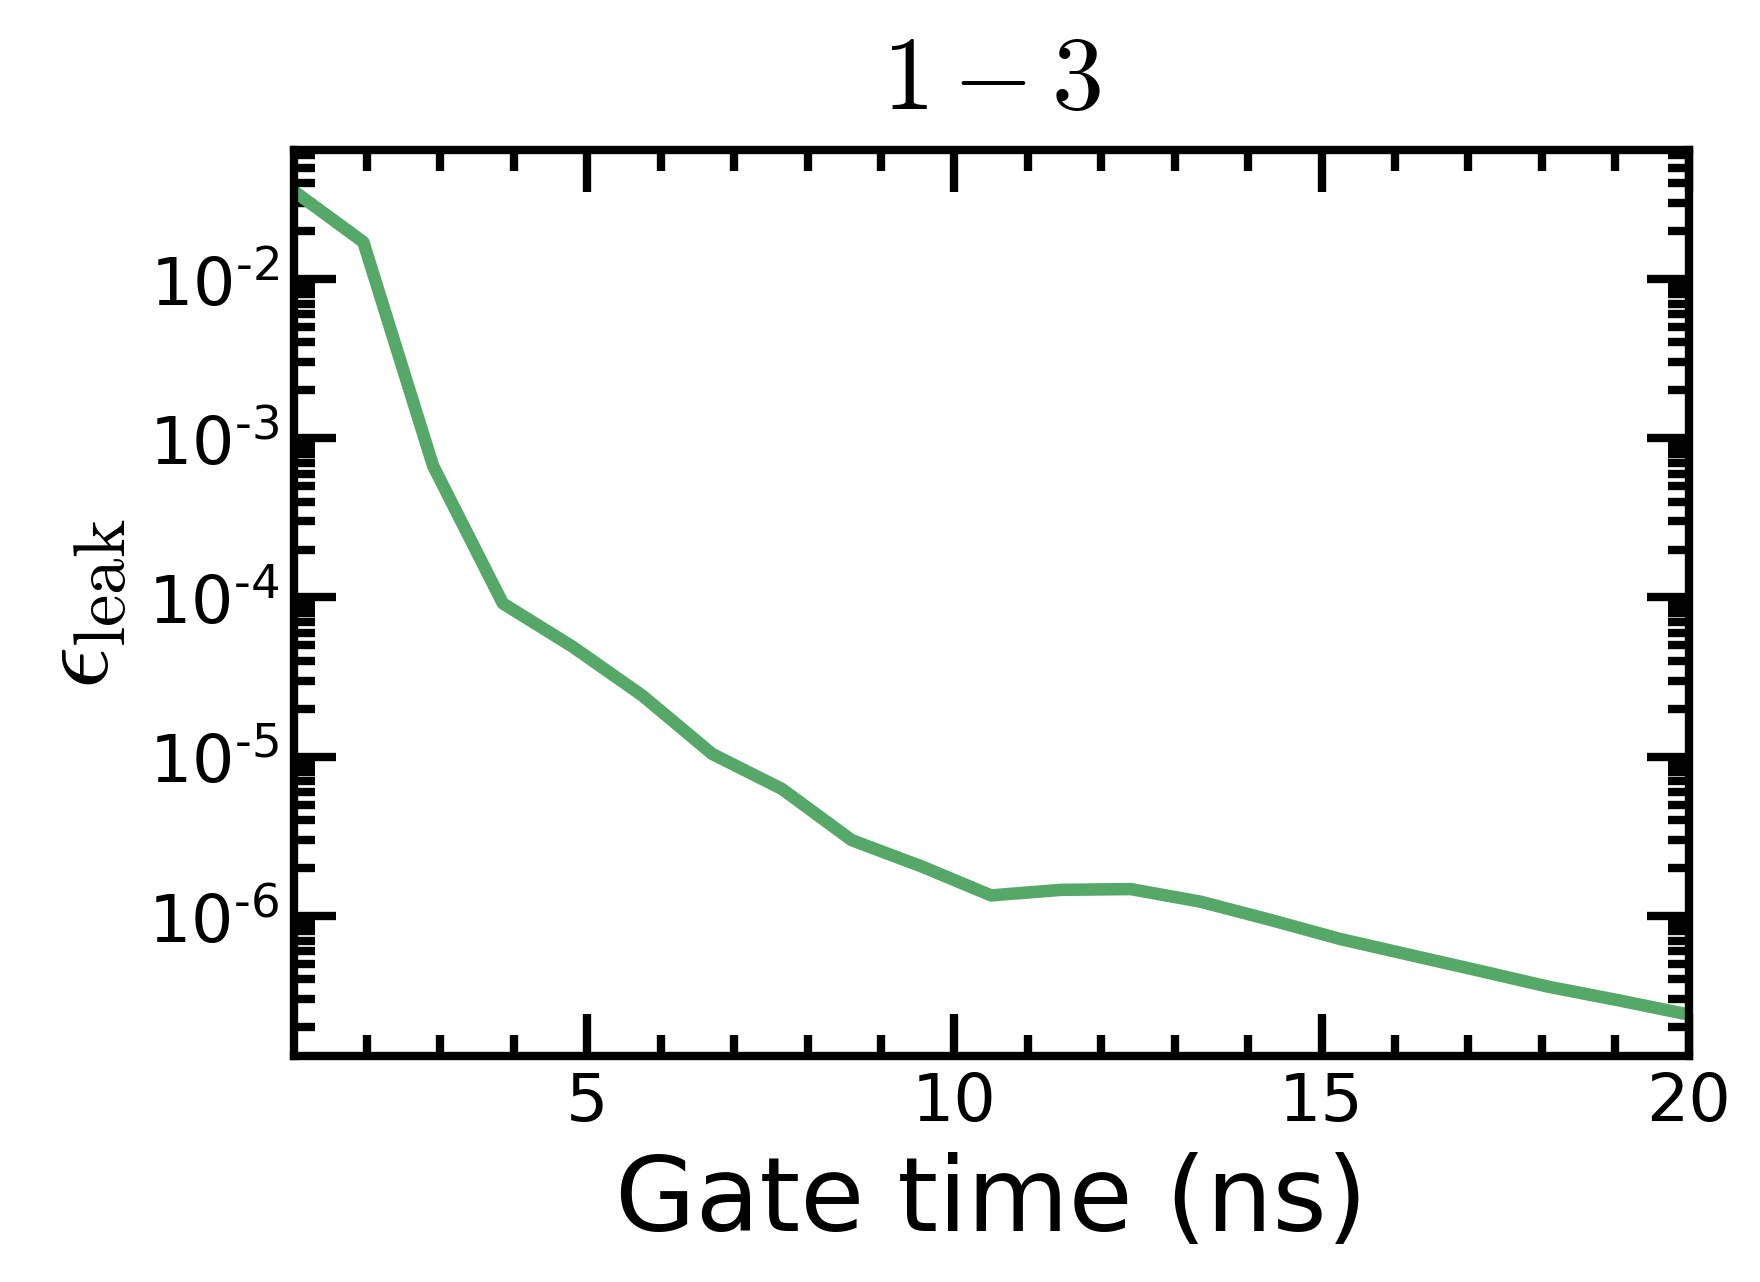

In [61]:
plt.semilogy(gate_time, leakage13, color = 'C1')
plt.xlabel('Gate time (ns)')
plt.ylabel(r'$\epsilon_\mathrm{leak}$')
plt.title(r'$1-3$')
plt.xlim([gate_time[0], gate_time[-1]])

(1.0, 20.0)

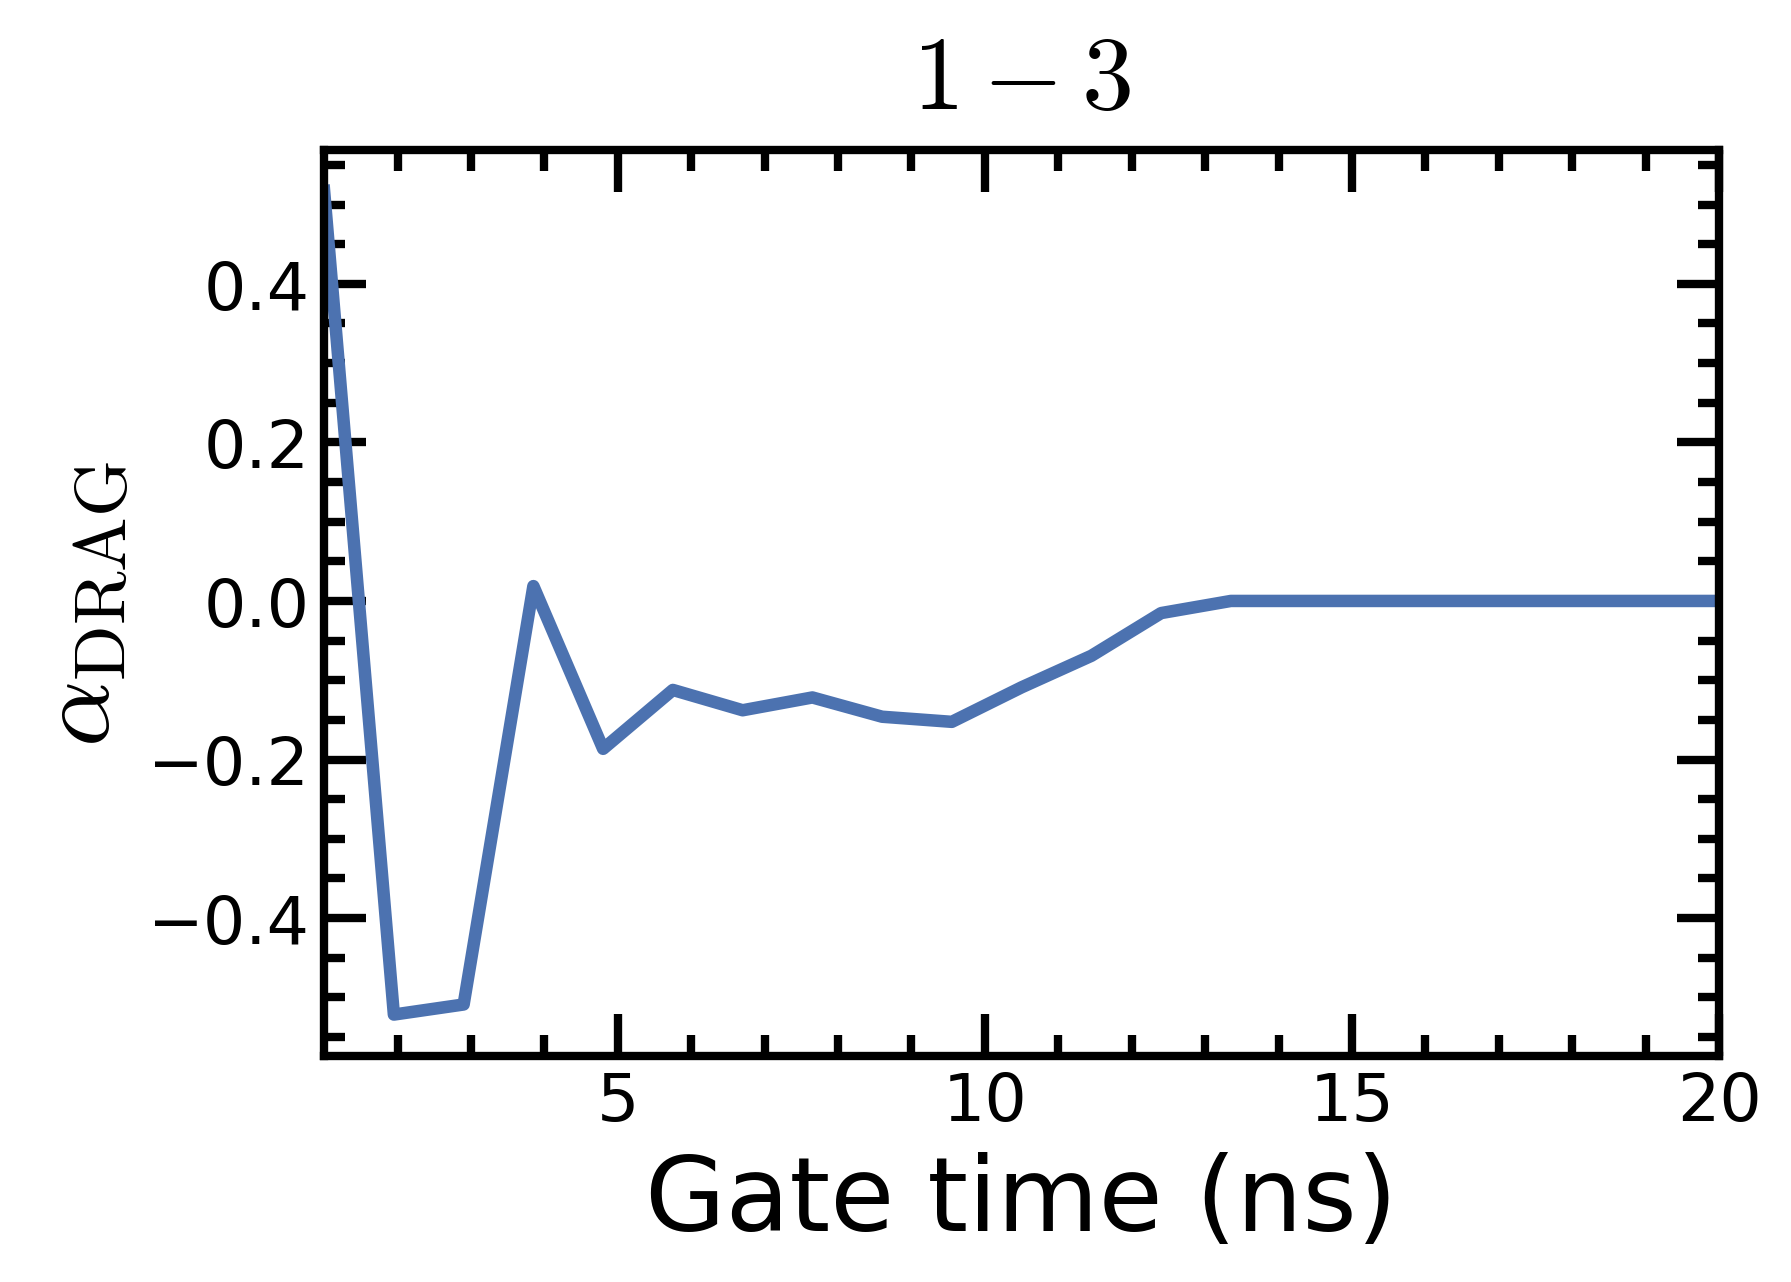

In [62]:
plt.plot(gate_time, drag_coeff_opt13)
plt.xlabel('Gate time (ns)')
plt.ylabel(r'$\alpha_\mathrm{DRAG}$')
plt.title(r'$1-3$')
plt.xlim([gate_time[0], gate_time[-1]])

## 2-3

In [63]:
#Gate parameter
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 0.25
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = False
drag_coeff = 0.5

ini_state = 2
fin_state = 3
psi_ini = psi2

comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient= drag_coeff)

Leakage error = 3.7479969794418366e-08


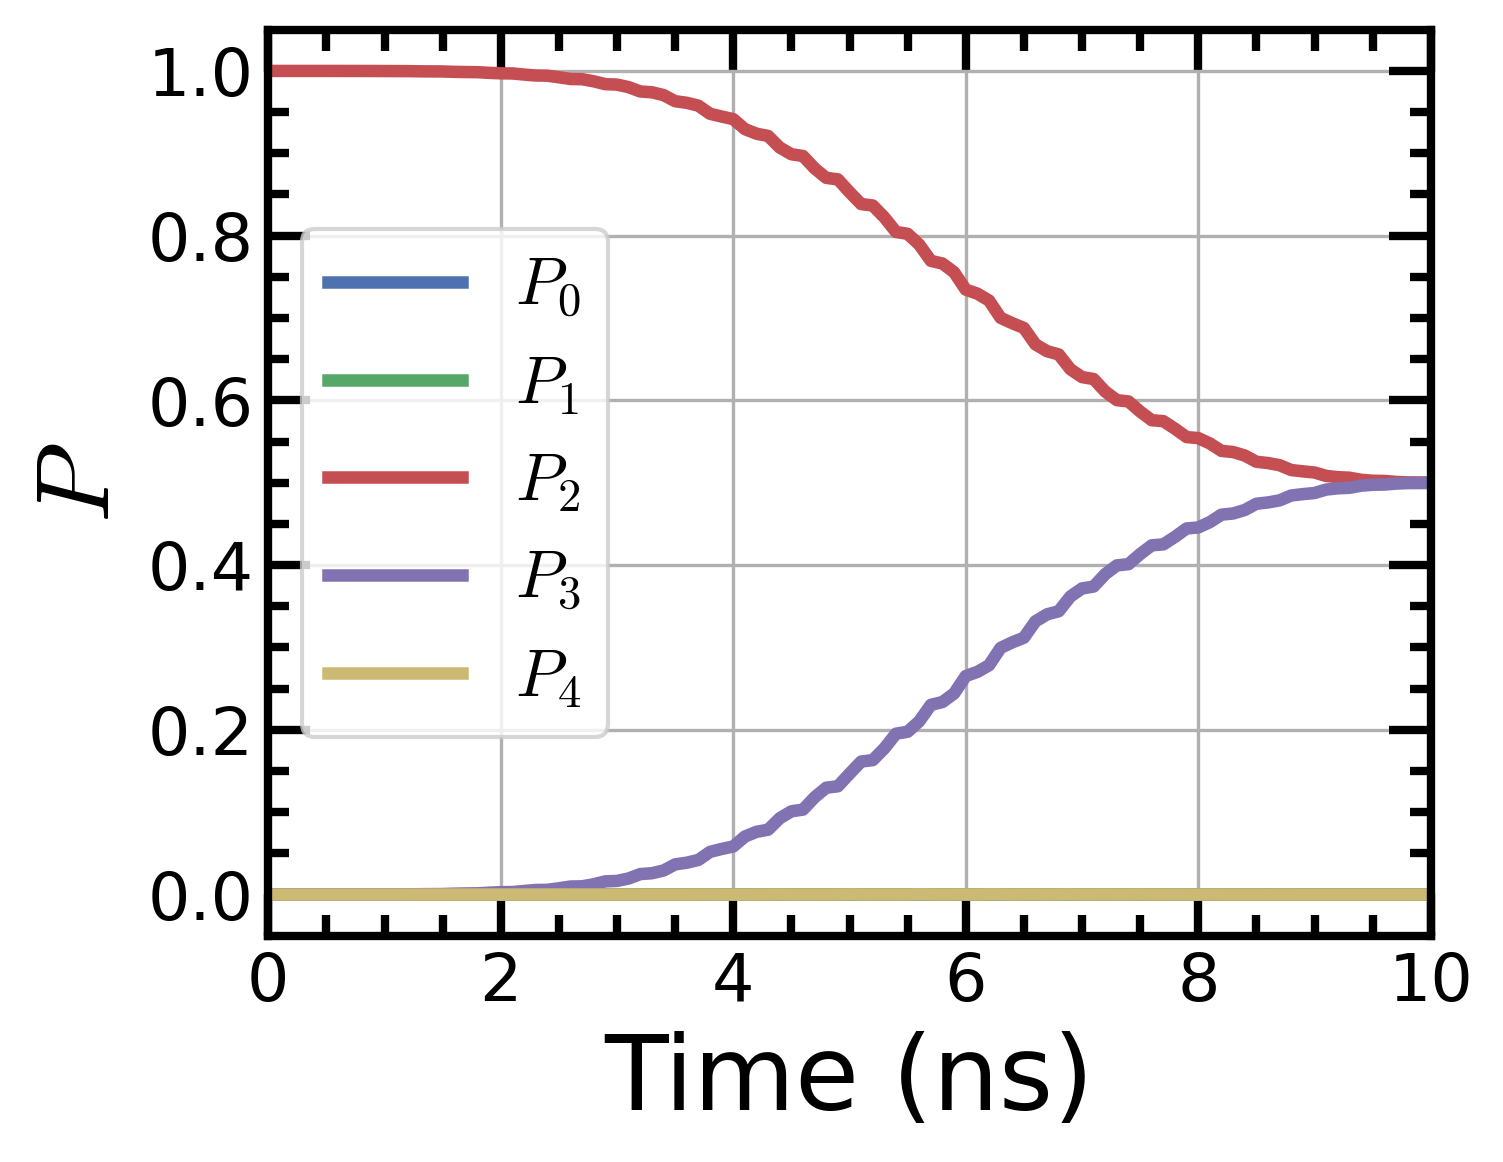

In [64]:
plt.figure(figsize = [5,4])
plt.plot(t_points, expect(P0,evol_states_ideal), label = r'$P_0$')
plt.plot(t_points, expect(P1,evol_states_ideal), label = r'$P_1$')
plt.plot(t_points, expect(P2,evol_states_ideal), label = r'$P_2$')
plt.plot(t_points, expect(P3,evol_states_ideal), label = r'$P_3$')
plt.plot(t_points, expect(P4,evol_states_ideal), label = r'$P_4$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.xlim([t_points[0],t_points[-1]])
plt.legend()
plt.grid()
# plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))
print ('Leakage error =', str(1-expect(P2,evol_states_ideal)[-1] - expect(P3,evol_states_ideal)[-1]))

In [65]:
leakage23 = np.zeros_like(gate_time)
drag = True
drag_coeff_opt23 = np.zeros_like(gate_time)
for idx,T_gate in enumerate(gate_time):
    t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
    def leakage_func(drag_coeff):
        evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient= drag_coeff)
        return (1-expect(P2,evol_states_ideal)[-1] - expect(P3,evol_states_ideal)[-1])
    opt = minimize(leakage_func, x0 = [0.0])
    leakage23[idx] = opt.fun
    drag_coeff_opt23 [idx] = opt.x[0]

(1.0, 20.0)

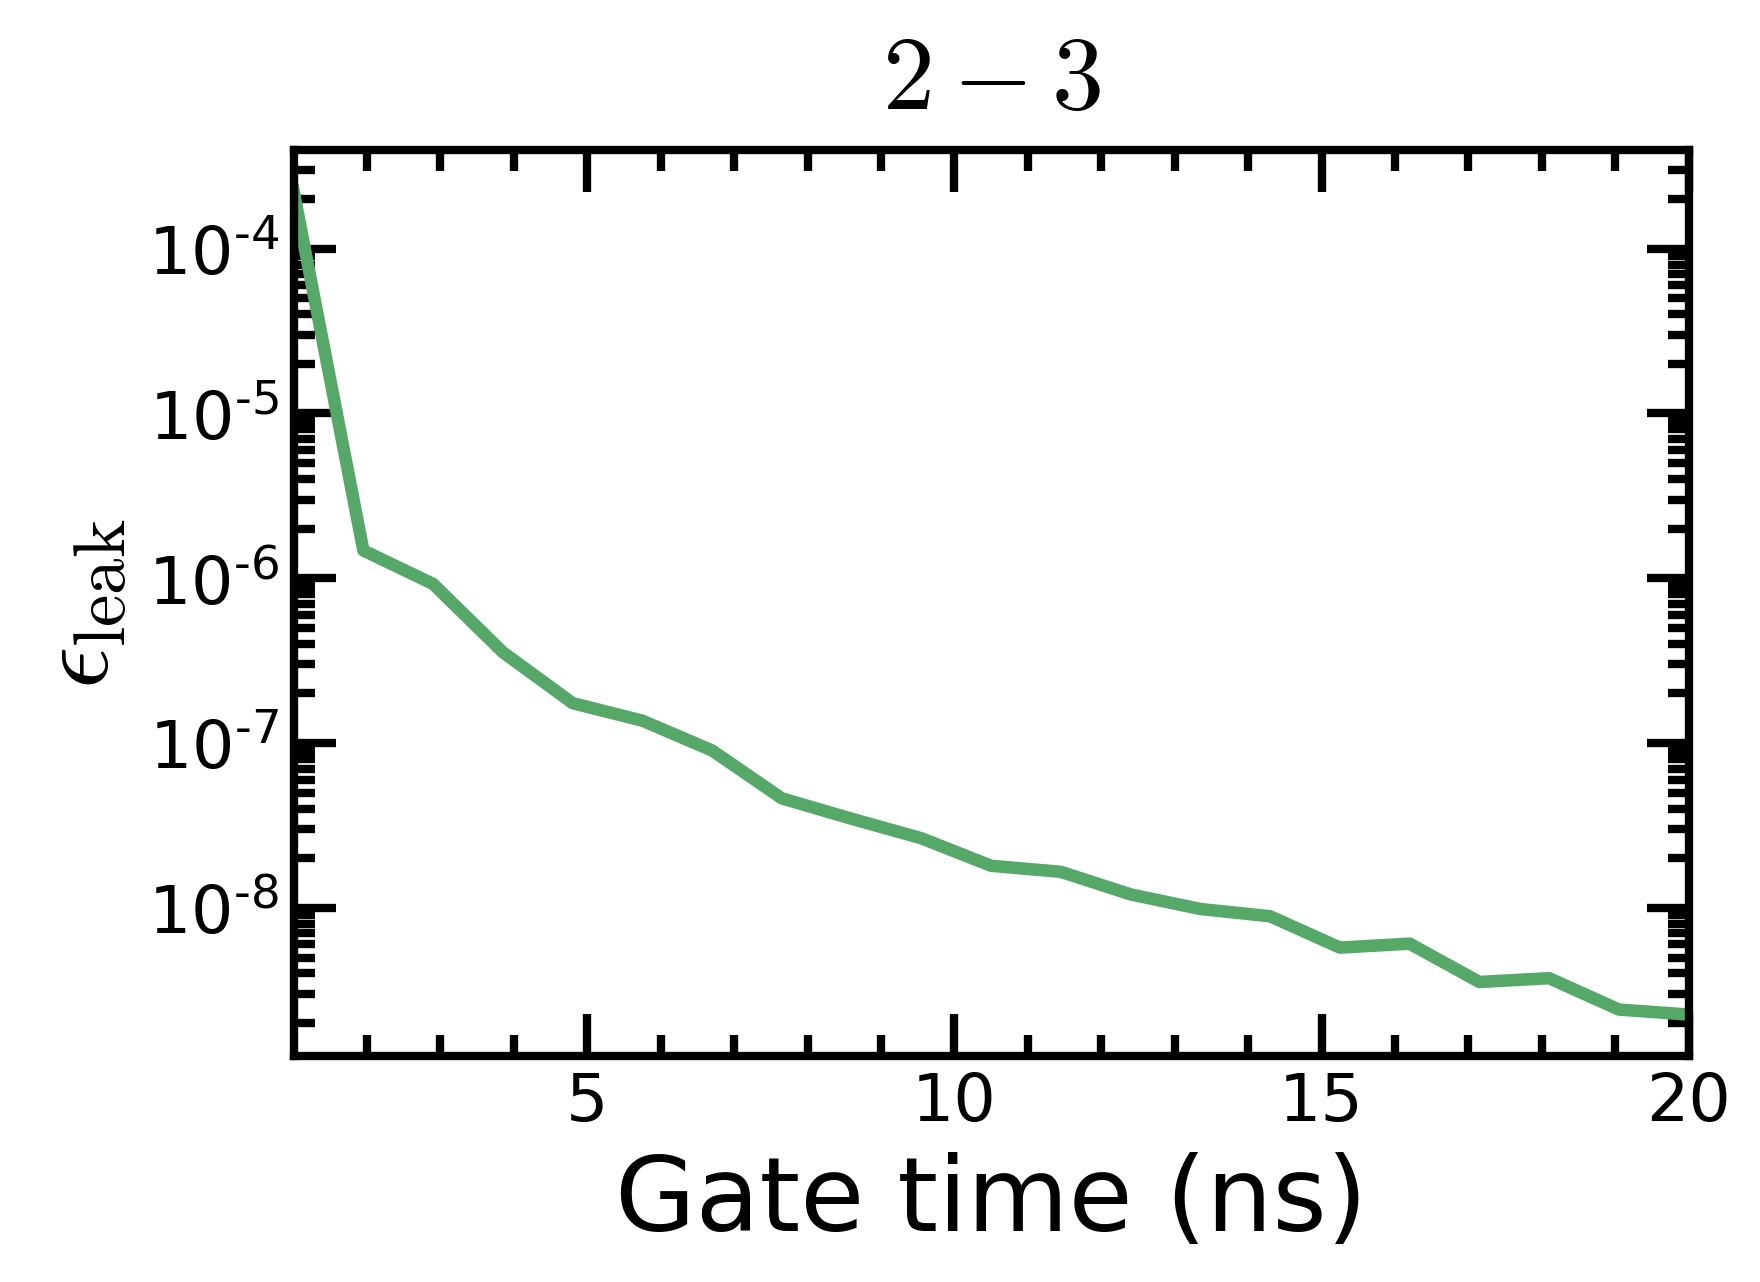

In [66]:
plt.semilogy(gate_time, leakage23, color = 'C1')
plt.xlabel('Gate time (ns)')
plt.ylabel(r'$\epsilon_\mathrm{leak}$')
plt.title(r'$2-3$')
plt.xlim([gate_time[0], gate_time[-1]])

(1.0, 20.0)

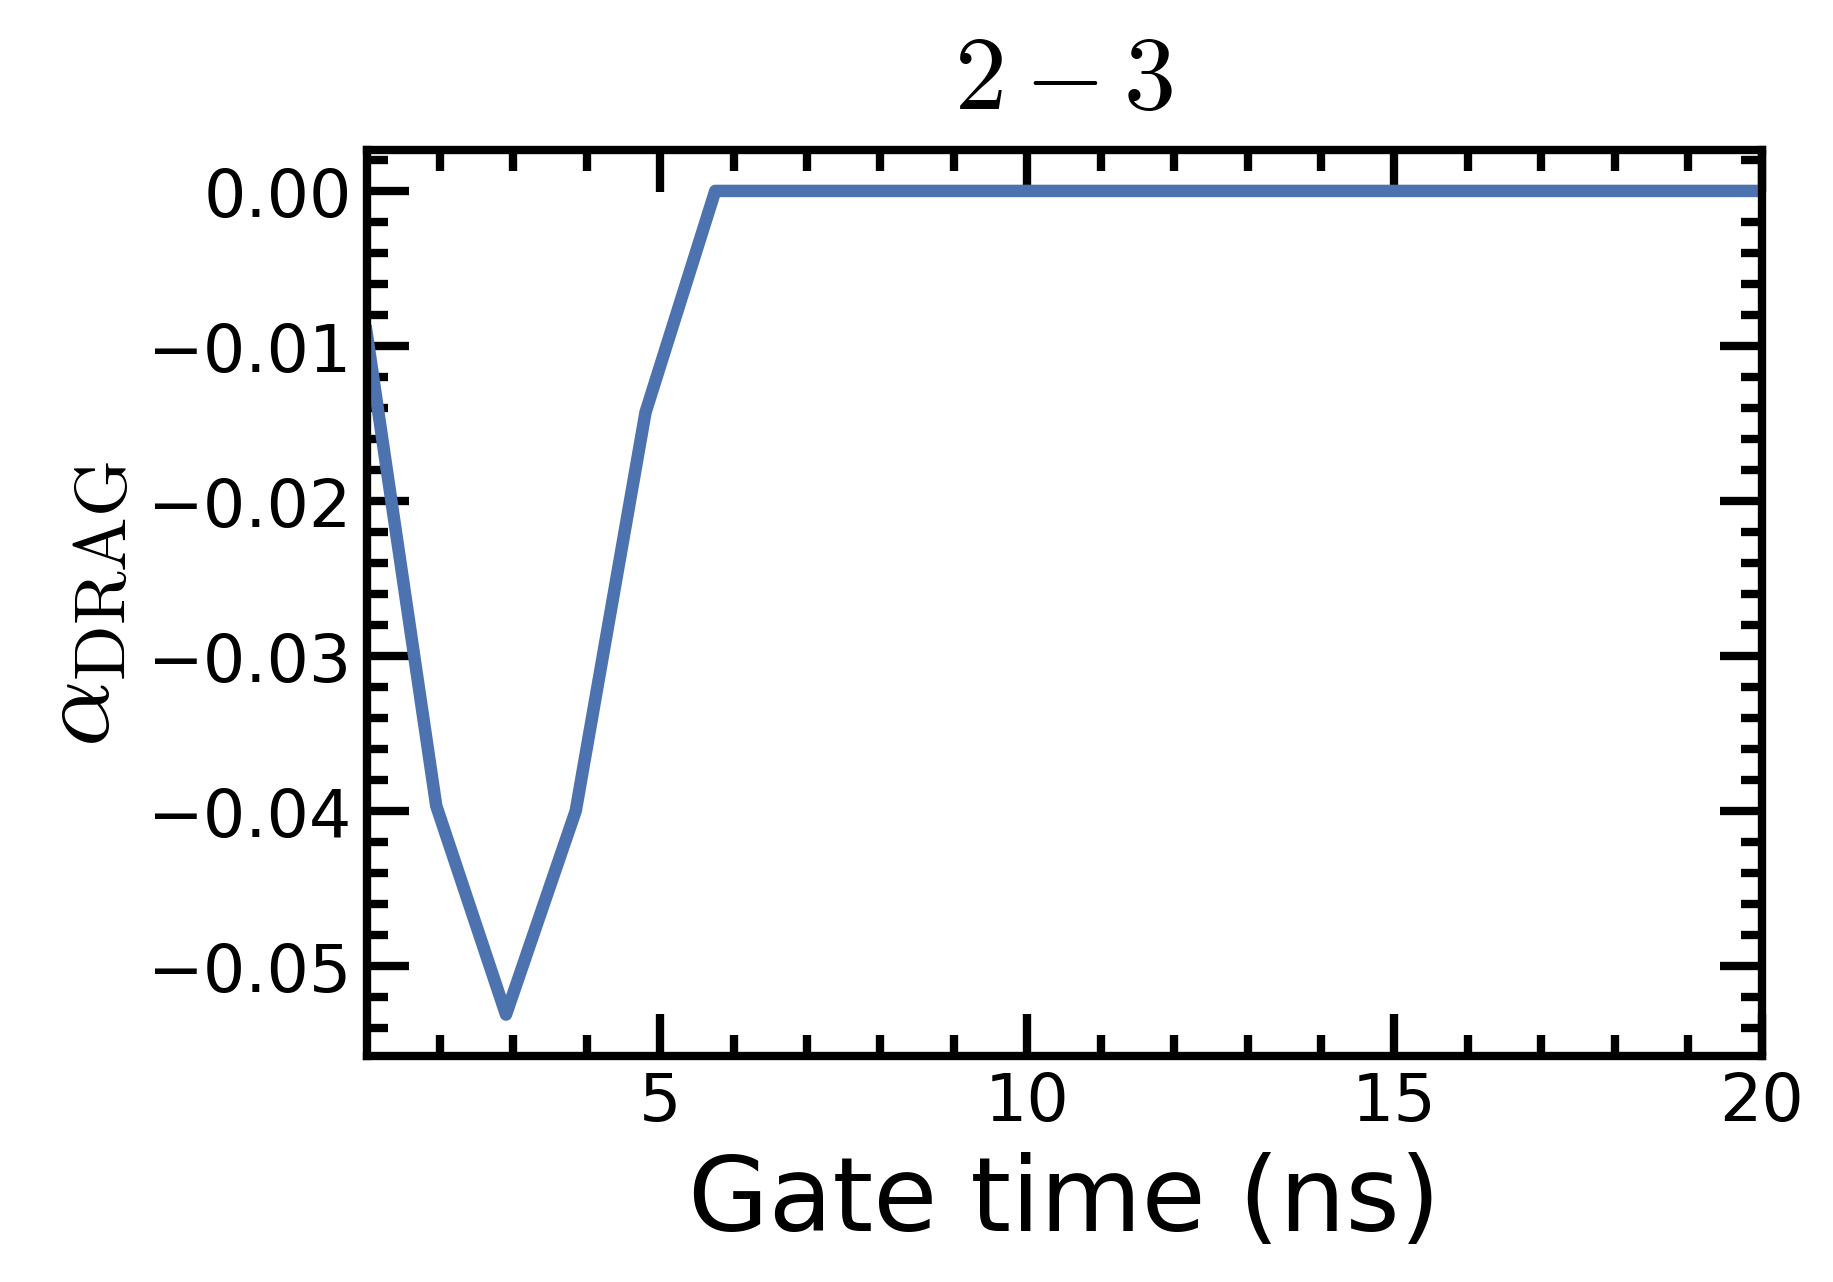

In [67]:
plt.plot(gate_time, drag_coeff_opt23)
plt.xlabel('Gate time (ns)')
plt.ylabel(r'$\alpha_\mathrm{DRAG}$')
plt.title(r'$2-3$')
plt.xlim([gate_time[0], gate_time[-1]])

## Combined gate

In [68]:
#Gate parameter
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor1 = 0.5
drive_amplitude_factor2 = 0.5
drive_amplitude_factor3 = 0.25
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff1 = 0.0
drag_coeff2 = 0.0
drag_coeff3 = -0.1

psi_ini = psi0

ini_state1 = 0
fin_state1 = 2
omega_d1 = qubit.freq(ini_state1,fin_state1)
matr_el1 = np.abs(qubit.n_ij(ini_state1,fin_state1))
epsilon1 = drive_amplitude_factor1/matr_el1
H_drive1 = epsilon1*(qubit.n())

ini_state2 = 1
fin_state2 = 3
omega_d2 = qubit.freq(ini_state2,fin_state2)
matr_el2 = np.abs(qubit.n_ij(ini_state2,fin_state2))
epsilon2 = drive_amplitude_factor2/matr_el2
H_drive2 = epsilon2*(qubit.n())

evol_states_ideal1 = gates.evolution_psi_microwave(H_nodrive, H_drive1, psi0 =psi_ini, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d1, DRAG_coefficient= drag_coeff1) 

evol_states_ideal2 = gates.evolution_psi_microwave(H_nodrive, H_drive2, psi0 =psi_ini, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d2, DRAG_coefficient= drag_coeff2)

# evol_states_ideal = evol_states_ideal1 + evol_states_ideal2

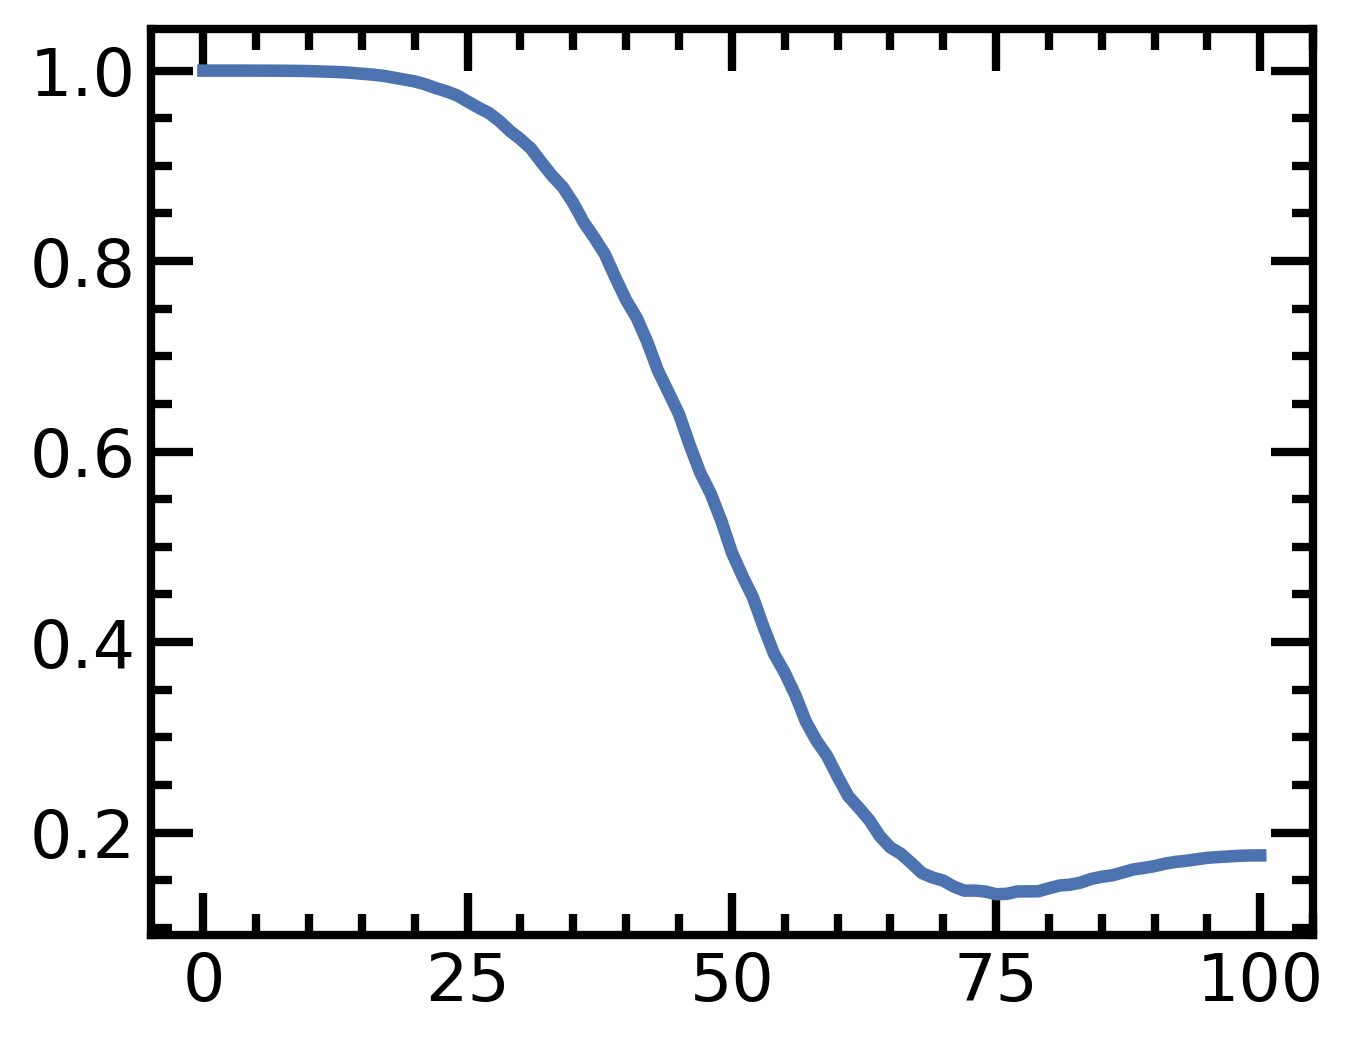

In [27]:
plt.figure(figsize = [5,4])
plt.plot(expect(P0,evol_states_ideal2), label = r'$P_0$')
# plt.plot(t_points, expect(P1,evol_states_ideal), label = r'$P_1$')
# plt.plot(t_points, expect(P2,evol_states_ideal), label = r'$P_2$')
# plt.plot(t_points, expect(P3,evol_states_ideal), label = r'$P_3$')
# plt.plot(t_points, expect(P4,evol_states_ideal), label = r'$P_4$')
# plt.xlabel('Time (ns)')
# plt.ylabel(r'$P$')
# plt.xlim([t_points[0],t_points[-1]])
# plt.legend()
# plt.grid()
# plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))
# print ('Leakage error =', str(1-expect(P2,evol_states_ideal)[-1] - expect(P3,evol_states_ideal)[-1]))